# Quarterback EDA & Hypothesis Testing

What makes a prospect a pick? I've collected all this data but what will really matter when predicting a round a prospect will be picked in. I know I want to model based for each of the following position groups:

        * Quarterbacks (QBs)
        * Receivers & Running Backs (Receivers)
        * Offensive Line (OffensiveLine)
        * Linebackers (LBs)
        * Defensive Backs (DefensiveBacks)
        * Special Teams (SpecialTeams)
        
Before I start modeling, I want to check out my data and get to know what will matter when trying to nail down just which round a prospect will be selected in. I start by visualizing the distribution of my outcome in a given position group. From there I pass each variable I think I may want in my model.

In this notebook, I look into my Quarterbacks data.

First things first, I need to load in my models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import scipy

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# setting format for readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_pickle('cleaned_df')

In [4]:
df.head()

PlayerName Position         School  CombineYear  Height  Weight  \
0  Shaun Alexander       RB        Alabama         2000      72     218   
1  LaVar Arrington      OLB     Penn State         2000      75     250   
2       John Baker        P    North Texas         2000      75     227   
3    Anthony Becht       TE  West Virginia         2000      78     270   
4        Tom Brady       QB       Michigan         2000      76     211   

   _40yd  Vertical  Bench  BroadJump  _3Cone  Shuttle             Draft Team  \
0   4.58      0.00   0.00       0.00    0.00     0.00      Seattle Seahawks    
1   4.53      0.00   0.00       0.00    0.00     0.00   Washington Redskins    
2   0.00      0.00   0.00       0.00    0.00     0.00                      0   
3   4.78     33.50   0.00     123.00    6.94     4.08         New York Jets    
4   5.28     24.50   0.00      99.00    7.20     4.38  New England Patriots    

         Round          Pick   Draft Year  Defense_Games  Solo_Tackles  \
0          1st    19th pick          2000           0.00          0.00   
1          1st     2nd pick          2000          12.00          0.00   
2  Not Drafted   Not Drafted  Not Drafted           0.00          0.00   
3          1st    27th pick          2000           0.00          0.00   
4          6th   199th pick          2000           0.00          0.00   

   Assisted_Tackles  Ttl_Tackles  Loss  Sacks  Defensive_Interceptions  \
0              0.00         0.00  0.00   0.00                     0.00   
1              0.00         0.00  0.00   0.00                     1.00   
2              0.00         0.00  0.00   0.00                     0.00   
3              0.00         0.00  0.00   0.00                     0.00   
4              0.00         0.00  0.00   0.00                     0.00   

   Def_Int_Yds  Yds_per_Int  Pick_6  Defended_Passes  Recovered_Fumbles  \
0         0.00         0.00    0.00             0.00               0.00   
1        27.00        27.00    0.00             0.00               0.00   
2         0.00         0.00    0.00             0.00               0.00   
3         0.00         0.00    0.00             0.00               0.00   
4         0.00         0.00    0.00             0.00               0.00   

   Rec_Fumbles_Yds  Fumbles_Returned_TD  Forced_Fumbles  Solo_TacklesperGame  \
0             0.00                 0.00            0.00                 0.00   
1             0.00                 0.00            0.00                 0.00   
2             0.00                 0.00            0.00                 0.00   
3             0.00                 0.00            0.00                 0.00   
4             0.00                 0.00            0.00                 0.00   

   Assisted_TacklesperGame  Ttl_TacklesperGame  LossperGame  SacksperGame  \
0                     0.00                0.00         0.00          0.00   
1                     0.00                0.00         0.00          0.00   
2                     0.00                0.00         0.00          0.00   
3                     0.00                0.00         0.00          0.00   
4                     0.00                0.00         0.00          0.00   

   Defensive_InterceptionsperGame  Def_Int_YdsperGame  Pick_6perGame  \
0                            0.00                0.00           0.00   
1                            0.08                2.25           0.00   
2                            0.00                0.00           0.00   
3                            0.00                0.00           0.00   
4                            0.00                0.00           0.00   

   Defended_PassesperGame  Recovered_FumblesperGame  Rec_Fumbles_YdsperGame  \
0                    0.00                      0.00                    0.00   
1                    0.00                      0.00                    0.00   
2                    0.00                      0.00                    0.00   
3                    0.00                 

## Functions

This is a lot of repetition so I build function to streamline the process over the 6 groups I need to investigate.

In [5]:
def position_family_df(position_family, df):
    """
    This funciton will filter for the specific position group - or family - I'm interested in for a 
    particular notebook. 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        
    Returns:
        dataframe: filtered dataframe
        
    """
    dataframe = df[df['Pos'] == position_family]
    return dataframe

In [24]:
def plot_outcomes(position_family, df):
    """
    This function returns the count for each round a given position group has and graphs it. Along with the count,
    it will also print the normalized count -- % to total -- as a point of comparison.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
    
    Returns:
        Dataframe shape, value counts for each round and the countplot for the distribution
        
    """
    dataframe = df
    print(position_family + ' Count: ')
    print('-'*40)
    print(position_family + ' Shape: ', dataframe.shape)
    print(dataframe['Round'].value_counts())
    print(round(dataframe['Round'].value_counts(normalize=True), 2))
    order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
    plt.figure(figsize=(10, 6))
    sns.countplot(dataframe['Round'],order=order, palette='bright');
    plt.title(position_family + ' Round Distribution')
    plt.savefig('images/' + position_family + '_round_distro')
    plt.show()

In [29]:
def plot_stats(position_family, df, lst):
    """
    The function returns the descriptive statistics for each item in a list. The list in question is a set of 
    feature I'm parsing through to determine if they're statistically significant. I want to first check their 
    distribution by plotting each feature's boxplot.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        lst: feature list
        
    Returns:
        Prints descriptive statistics, mean by Round for the feature and plots the distribution boxplot.
    
    """
    for i in lst:
        dataframe = df
        order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
        print(position_family + ' ' + i + ' Summary:')
        print(dataframe[i].describe())
        print('-' * 40)
        print(position_family + ' ' + i + ' by Round')
        print(dataframe[['Round', i]].groupby(['Round']).mean())
        plt.figure(figsize = (10,6))
        plt.title(position_family + ' ' + i + ' Distribution')
        sns.boxplot(y=dataframe[i], x=dataframe['Round'], order=order)
        plt.savefig('images/' + position_family + '_' + i + '_Distro')
        plt.show()

In [21]:
def anova_tukey(position_family, df, feature):
    """
    This function runs the ANOVA test checking for significance between a given feature and the output variable along
    with the 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        feature: feature being tested  
        
    Returns:
        Prints ANOVA test summary and Tukey-MC analysis
    
    """
    dataframe = df
    anova_rounds = ols(feature + '~Round', data=dataframe).fit()
    anova_rounds
    anova_table = sm.stats.anova_lm(anova_rounds, type=2)
    print(anova_table)
    print('')
    mc = MultiComparison(dataframe[feature], dataframe['Round'])
    mc_results = mc.tukeyhsd()
    print(mc_results.summary())

## EDA & Hypothesis Testing

In [22]:
df = position_family_df('QBs', df)
df.head()

PlayerName Position         School  CombineYear  Height  Weight  \
4         Tom Brady       QB       Michigan         2000      76     211   
7       Marc Bulger       QB  West Virginia         2000      74     208   
37     Joe Hamilton       QB   Georgia Tech         2000      70     192   
40       Todd Husak       QB       Stanford         2000      75     216   
42  Jarious Jackson       QB     Notre Dame         2000      72     226   

    _40yd  Vertical  Bench  BroadJump  _3Cone  Shuttle             Draft Team  \
4    5.28     24.50   0.00      99.00    7.20     4.38  New England Patriots    
7    4.97      0.00   0.00     100.00    7.46     4.34    New Orleans Saints    
37   4.81      0.00   0.00     106.00    0.00     0.00  Tampa Bay Buccaneers    
40   5.20     27.50   0.00      99.00    7.17     4.41   Washington Redskins    
42   4.68      0.00   0.00     109.00    0.00     0.00        Denver Broncos    

   Round          Pick Draft Year  Defense_Games  Solo_Tackles  \
4    6th   199th pick        2000           0.00          0.00   
7    6th   168th pick        2000           0.00          0.00   
37   7th   234th pick        2000           0.00          0.00   
40   6th   202nd pick        2000           0.00          0.00   
42   7th   214th pick        2000           0.00          0.00   

    Assisted_Tackles  Ttl_Tackles  Loss  Sacks  Defensive_Interceptions  \
4               0.00         0.00  0.00   0.00                     0.00   
7               0.00         0.00  0.00   0.00                     0.00   
37              0.00         0.00  0.00   0.00                     0.00   
40              0.00         0.00  0.00   0.00                     0.00   
42              0.00         0.00  0.00   0.00                     0.00   

    Def_Int_Yds  Yds_per_Int  Pick_6  Defended_Passes  Recovered_Fumbles  \
4          0.00         0.00    0.00             0.00               0.00   
7          0.00         0.00    0.00             0.00               0.00   
37         0.00         0.00    0.00             0.00               0.00   
40         0.00         0.00    0.00             0.00               0.00   
42         0.00         0.00    0.00             0.00               0.00   

    Rec_Fumbles_Yds  Fumbles_Returned_TD  Forced_Fumbles  Solo_TacklesperGame  \
4              0.00                 0.00            0.00                 0.00   
7              0.00                 0.00            0.00                 0.00   
37             0.00                 0.00            0.00                 0.00   
40             0.00                 0.00            0.00                 0.00   
42             0.00                 0.00            0.00                 0.00   

    Assisted_TacklesperGame  Ttl_TacklesperGame  LossperGame  SacksperGame  \
4                      0.00                0.00         0.00          0.00   
7                      0.00                0.00         0.00          0.00   
37                     0.00                0.00         0.00          0.00   
40                     0.00                0.00         0.00          0.00   
42                     0.00                0.00         0.00          0.00   

    Defensive_InterceptionsperGame  Def_Int_YdsperGame  Pick_6perGame  \
4                             0.00                0.00           0.00   
7                             0.00                0.00           0.00   
37                            0.00                0.00           0.00   
40                            0.00                0.00           0.00   
42                            0.00                0.00           0.00   

    Defended_PassesperGame  Recovered_FumblesperGame  Rec_Fumbles_YdsperGame  \
4                     0.00                      0.00                    0.00   
7                     0.00                      0.00                    0.00   
37                    0.00                      0.00                    0.00   
40                    0.00                   

QBs Count: 
----------------------------------------
QBs Shape:  (332, 121)
Not Drafted    116
1st             59
6th             34
4th             28
3rd             25
7th             25
5th             24
2nd             21
Name: Round, dtype: int64
Not Drafted   0.35
1st           0.18
6th           0.10
4th           0.08
3rd           0.08
7th           0.08
5th           0.07
2nd           0.06
Name: Round, dtype: float64


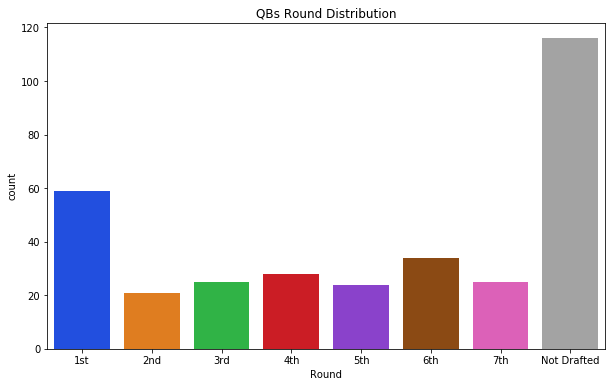

In [25]:
plot_outcomes('QBs', df)

### Height & Weight

In [30]:
height_weight = ['Height', 'Weight']

QBs Height Summary:
count   332.00
mean     74.78
std       1.76
min      70.00
25%      74.00
50%      75.00
75%      76.00
max      79.00
Name: Height, dtype: float64
----------------------------------------
QBs Height by Round
             Height
Round              
1st           75.41
2nd           74.62
3rd           75.84
4th           75.04
5th           74.83
6th           75.15
7th           74.20
Not Drafted   74.20


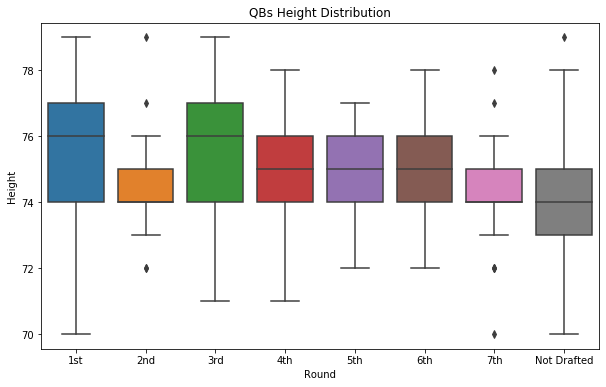

QBs Weight Summary:
count   332.00
mean    222.82
std      11.54
min     192.00
25%     215.00
50%     223.00
75%     229.00
max     288.00
Name: Weight, dtype: float64
----------------------------------------
QBs Weight by Round
             Weight
Round              
1st          227.10
2nd          222.71
3rd          226.28
4th          224.75
5th          221.00
6th          220.62
7th          220.72
Not Drafted  220.92


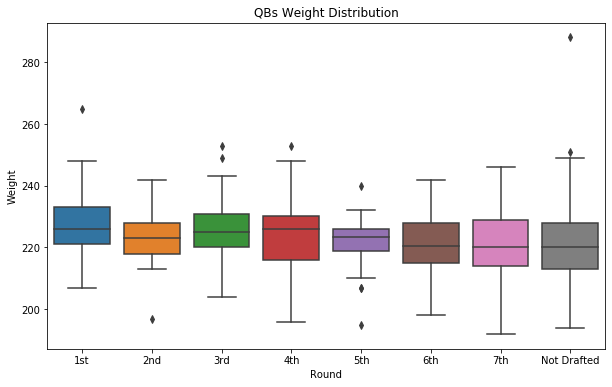

In [31]:
plot_stats('QBs', df, height_weight)

In [557]:
anova_tukey('QBs', df, 'Height')

             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00  105.95    15.14 5.32    0.00
Residual 324.00  921.55     2.84  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.7877 0.5812 -2.0951  0.5197  False
   1st         3rd   0.4332    0.9 -0.7946  1.6611  False
   1st         4th  -0.3711    0.9 -1.5518  0.8097  False
   1st         5th  -0.5734 0.8387 -1.8191  0.6722  False
   1st         6th  -0.2597    0.9 -1.3676  0.8481  False
   1st         7th  -1.2068 0.0581 -2.4346  0.0211  False
   1st Not Drafted  -1.2085  0.001 -2.0313 -0.3858   True
   2nd         3rd    1.221 0.2232 -0.3021   2.744  False
   2nd         4th   0.4167    0.9 -1.0686   1.902  False
   2nd         5th   0.2143    0.9 -1.3231  1.7517  False
   2nd         6th    0.528    0.9    -0.9   1.956  False
   2nd         7th   -0.419    0.9 -1.9421   1.10

In [32]:
anova_tukey('QBs', df, 'Weight')

             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00  2257.82   322.55 2.50    0.02
Residual 324.00 41843.34   129.15  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd  -4.3874 0.7704 -13.1972  4.4224  False
   1st         3rd  -0.8217    0.9  -9.0954   7.452  False
   1st         4th  -2.3517    0.9  -10.308  5.6046  False
   1st         5th  -6.1017 0.3442 -14.4956  2.2922  False
   1st         6th   -6.484  0.142 -13.9491   0.981  False
   1st         7th  -6.3817 0.2684 -14.6554   1.892  False
   1st Not Drafted  -6.1793 0.0171 -11.7232 -0.6353   True
   2nd         3rd   3.5657    0.9  -6.6968 13.8283  False
   2nd         4th   2.0357    0.9  -7.9727 12.0441  False
   2nd         5th  -1.7143    0.9  -12.074  8.6454  False
   2nd         6th  -2.0966    0.9 -11.7192  7.5259  False
   2nd         7th  -1.9943    0

### Combine Stats

In [33]:
combine_columns = df[['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']]
combine_columns.describe()

_40yd  Vertical  Bench  BroadJump  _3Cone  Shuttle
count 332.00    332.00 332.00     332.00  332.00   332.00
mean    4.63     25.43   0.88      90.77    5.41     3.33
std     0.95     12.43   3.99      43.10    3.08     1.84
min     0.00      0.00   0.00       0.00    0.00     0.00
25%     4.68     26.50   0.00     101.00    6.68     4.01
50%     4.81     30.00   0.00     109.00    7.06     4.28
75%     4.92     33.00   0.00     114.00    7.24     4.42
max     5.37     39.00  24.00     127.00    7.93     4.78

In [34]:
combine_stats = ['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']

QBs _40yd Summary:
count   332.00
mean      4.63
std       0.95
min       0.00
25%       4.68
50%       4.81
75%       4.92
max       5.37
Name: _40yd, dtype: float64
----------------------------------------
QBs _40yd by Round
             _40yd
Round             
1st           4.36
2nd           4.74
3rd           4.69
4th           4.82
5th           4.62
6th           4.28
7th           4.82
Not Drafted   4.75


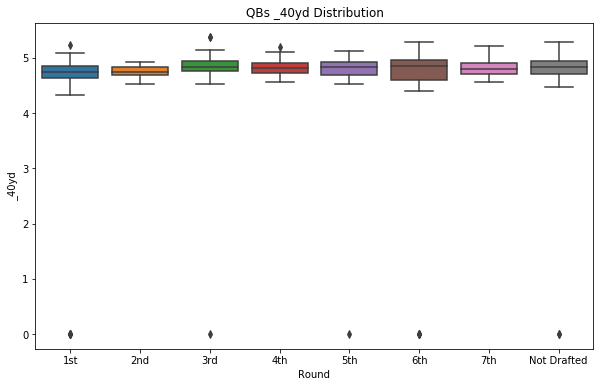

QBs Vertical Summary:
count   332.00
mean     25.43
std      12.43
min       0.00
25%      26.50
50%      30.00
75%      33.00
max      39.00
Name: Vertical, dtype: float64
----------------------------------------
QBs Vertical by Round
             Vertical
Round                
1st             21.08
2nd             27.38
3rd             25.86
4th             27.38
5th             25.38
6th             24.97
7th             22.38
Not Drafted     27.53


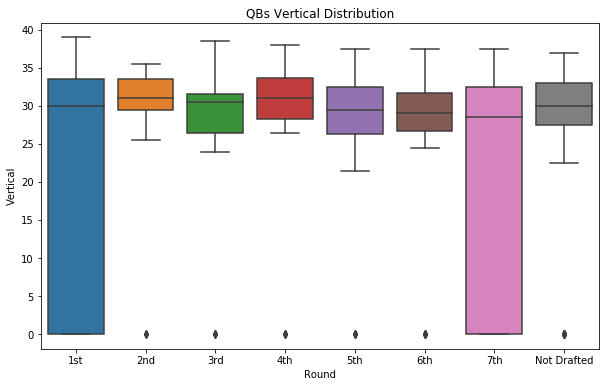

QBs Bench Summary:
count   332.00
mean      0.88
std       3.99
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      24.00
Name: Bench, dtype: float64
----------------------------------------
QBs Bench by Round
             Bench
Round             
1st           0.80
2nd           1.05
3rd           0.76
4th           0.79
5th           0.00
6th           0.00
7th           0.80
Not Drafted   1.40


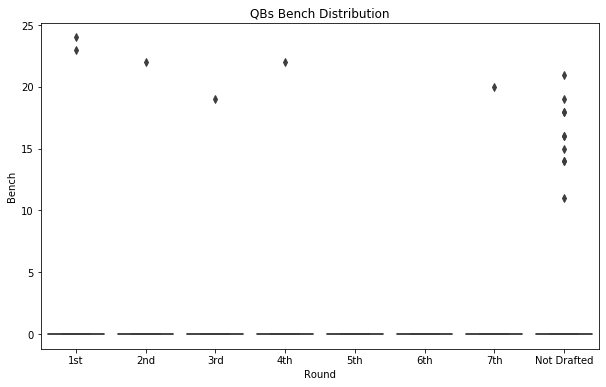

QBs BroadJump Summary:
count   332.00
mean     90.77
std      43.10
min       0.00
25%     101.00
50%     109.00
75%     114.00
max     127.00
Name: BroadJump, dtype: float64
----------------------------------------
QBs BroadJump by Round
             BroadJump
Round                 
1st              72.19
2nd              96.29
3rd              92.12
4th              89.25
5th              90.67
6th              92.12
7th              87.20
Not Drafted      99.71


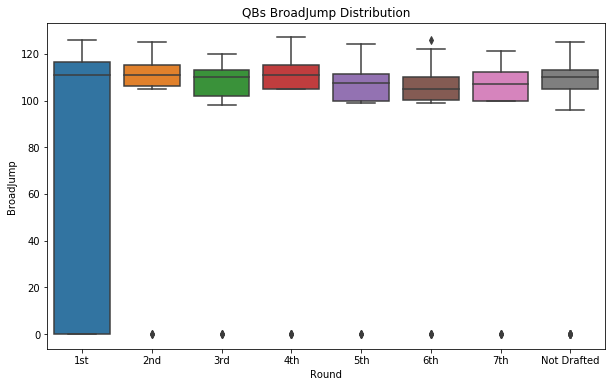

QBs _3Cone Summary:
count   332.00
mean      5.41
std       3.08
min       0.00
25%       6.68
50%       7.06
75%       7.24
max       7.93
Name: _3Cone, dtype: float64
----------------------------------------
QBs _3Cone by Round
             _3Cone
Round              
1st            4.40
2nd            5.05
3rd            5.19
4th            5.88
5th            5.37
6th            5.52
7th            5.16
Not Drafted    5.94


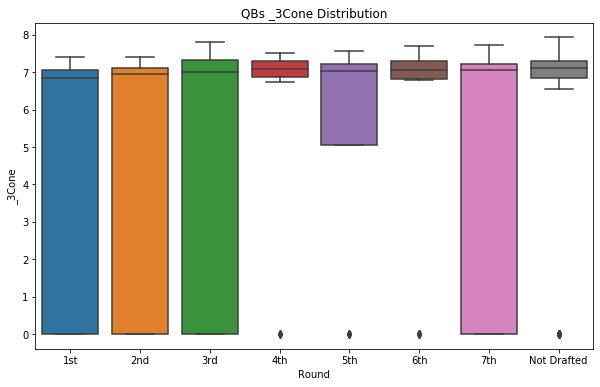

QBs Shuttle Summary:
count   332.00
mean      3.33
std       1.84
min       0.00
25%       4.01
50%       4.28
75%       4.42
max       4.78
Name: Shuttle, dtype: float64
----------------------------------------
QBs Shuttle by Round
             Shuttle
Round               
1st             2.60
2nd             3.29
3rd             3.09
4th             3.57
5th             3.22
6th             3.33
7th             3.11
Not Drafted     3.77


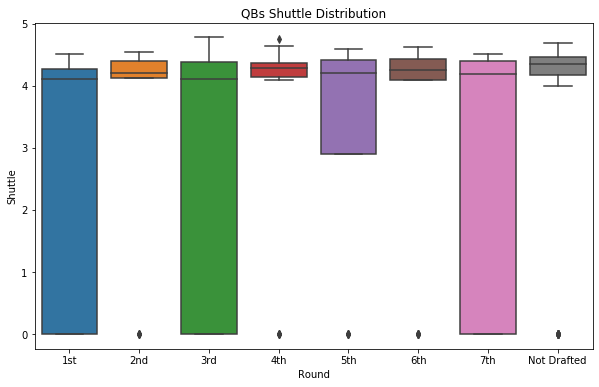

In [35]:
plot_stats('QBs', df, combine_stats)

In [36]:
for i in combine_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', df, i)
    print('')
    print('*' * 60)

_40yd ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   12.33     1.76 1.99    0.06
Residual 324.00  287.03     0.89  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.3752  0.741 -0.3544 1.1049  False
   1st         3rd   0.3312  0.797 -0.3541 1.0165  False
   1st         4th   0.4607 0.3982 -0.1983 1.1197  False
   1st         5th   0.2625    0.9 -0.4327 0.9577  False
   1st         6th  -0.0779    0.9 -0.6962 0.5403  False
   1st         7th   0.4576 0.4606 -0.2277 1.1429  False
   1st Not Drafted   0.3907 0.1613 -0.0685 0.8499  False
   2nd         3rd   -0.044    0.9  -0.894 0.8059  False
   2nd         4th   0.0855    0.9 -0.7435 0.9144  False
   2nd         5th  -0.1127    0.9 -0.9708 0.7453  False
   2nd         6th  -0.4532 0.6426 -1.2501 0.3438  False
   2

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.6927  0.777 -0.7084 2.0939  False
   1st         3rd    0.494    0.9 -0.8219 1.8099  False
   1st         4th   0.9704 0.2756 -0.2951 2.2358  False
   1st         5th   0.6211 0.8297 -0.7139 1.9562  False
   1st         6th   0.7297 0.5593 -0.4576  1.917  False
   1st         7th   0.5132    0.9 -0.8027 1.8291  False
   1st Not Drafted   1.1725 0.0016  0.2908 2.0543   True
   2nd         3rd  -0.1987    0.9  -1.831 1.4335  False
   2nd         4th   0.2776    0.9 -1.3142 1.8694  False
   2nd         5th  -0.0716    0.9 -1.7193 1.5761  False
   2nd         6th   0.0369    0.9 -1.4935 1.5674  False
   2nd         7th  -0.1795    0.9 -1.8118 1.4527  False
   2nd Not Drafted   0.4798    0.9 -0.8279 1.7875  False
   3rd         4th   0.4763    0.9  -1.041 1.9936  False
   3rd         5th   0.1271    

### College Stats - Passing

In [37]:
passing_stats = ['Passing_Games', 'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                 'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 'Pass_Interceptions', 'Passer_Rating', 
                 'CompletionsperGame', 'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                 'Pass_InterceptionsperGame']

QBs Passing_Games Summary:
count   332.00
mean     12.05
std       1.93
min       0.00
25%      11.00
50%      13.00
75%      13.00
max      15.00
Name: Passing_Games, dtype: float64
----------------------------------------
QBs Passing_Games by Round
             Passing_Games
Round                     
1st                  12.47
2nd                  11.76
3rd                  12.08
4th                  11.86
5th                  11.62
6th                  11.79
7th                  12.56
Not Drafted          11.98


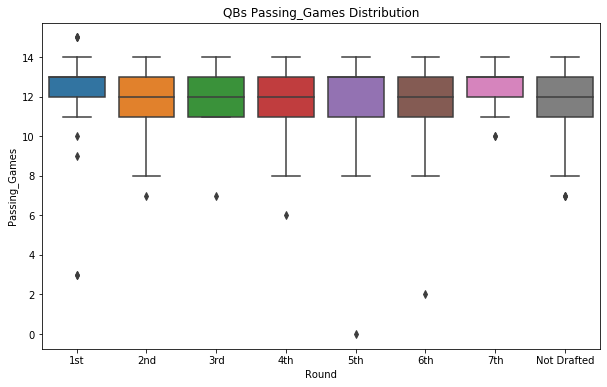

QBs Completions Summary:
count   332.00
mean    239.59
std      81.39
min       0.00
25%     188.75
50%     237.00
75%     289.00
max     493.00
Name: Completions, dtype: float64
----------------------------------------
QBs Completions by Round
             Completions
Round                   
1st               266.32
2nd               236.19
3rd               256.92
4th               227.86
5th               211.42
6th               255.18
7th               253.64
Not Drafted       223.95


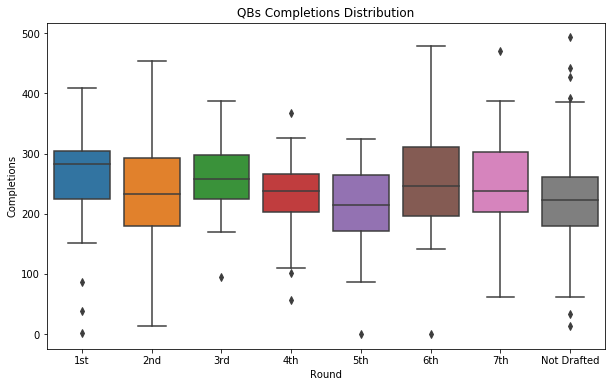

QBs Pass_Attempts Summary:
count   332.00
mean    383.37
std     115.06
min       0.00
25%     313.75
50%     391.00
75%     451.25
max     719.00
Name: Pass_Attempts, dtype: float64
----------------------------------------
QBs Pass_Attempts by Round
             Pass_Attempts
Round                     
1st                 410.00
2nd                 370.43
3rd                 409.60
4th                 371.96
5th                 341.88
6th                 407.71
7th                 405.00
Not Drafted         366.07


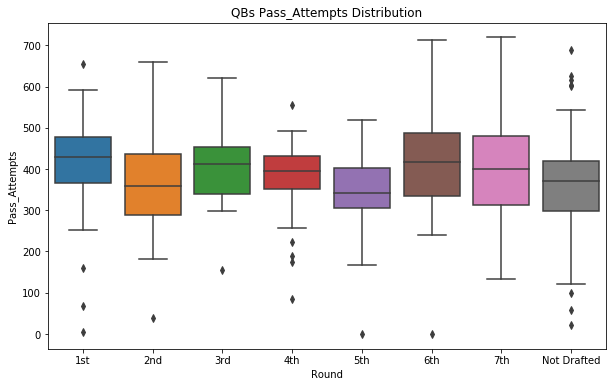

QBs Completion_Percent Summary:
count   332.00
mean     61.36
std       7.66
min       0.00
25%      58.20
50%      62.30
75%      65.70
max      76.30
Name: Completion_Percent, dtype: float64
----------------------------------------
QBs Completion_Percent by Round
             Completion_Percent
Round                          
1st                       64.03
2nd                       61.75
3rd                       62.52
4th                       61.00
5th                       59.04
6th                       60.11
7th                       61.84
Not Drafted               60.52


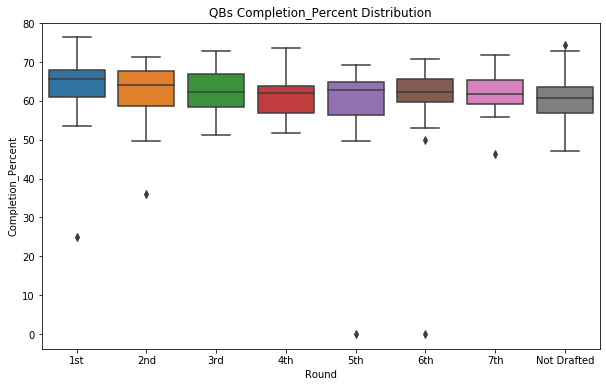

QBs Pass_Yards Summary:
count    332.00
mean    3042.95
std      983.53
min        0.00
25%     2505.75
50%     3068.00
75%     3616.25
max     5833.00
Name: Pass_Yards, dtype: float64
----------------------------------------
QBs Pass_Yards by Round
             Pass_Yards
Round                  
1st             3476.59
2nd             2982.95
3rd             3171.92
4th             2953.93
5th             2706.92
6th             3170.53
7th             3267.72
Not Drafted     2810.65


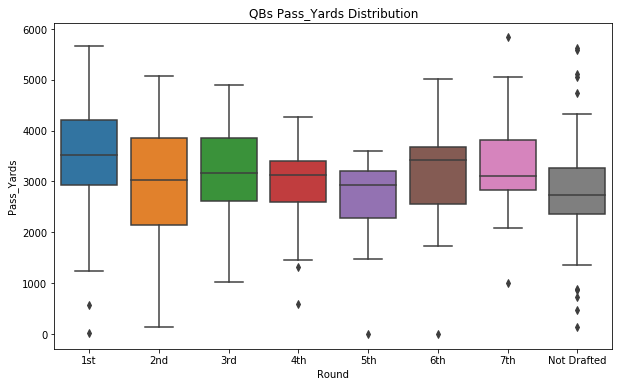

QBs Pass_Yds_per_Attempt Summary:
count   332.00
mean      7.85
std       1.26
min       0.00
25%       7.18
50%       7.70
75%       8.60
max      11.60
Name: Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
QBs Pass_Yds_per_Attempt by Round
             Pass_Yds_per_Attempt
Round                            
1st                          8.43
2nd                          7.80
3rd                          7.72
4th                          7.92
5th                          7.67
6th                          7.59
7th                          8.11
Not Drafted                  7.64


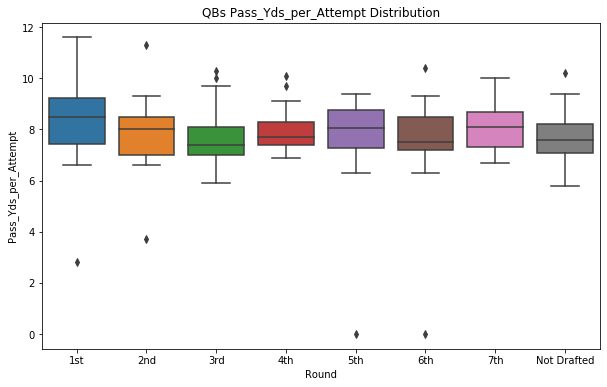

QBs Adj_Pass_Yds_per_Attempt Summary:
count   332.00
mean      7.83
std       3.33
min     -45.00
25%       6.90
50%       7.90
75%       9.03
max      13.40
Name: Adj_Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
QBs Adj_Pass_Yds_per_Attempt by Round
             Adj_Pass_Yds_per_Attempt
Round                                
1st                              8.86
2nd                              7.96
3rd                              7.82
4th                              7.92
5th                              7.85
6th                              6.36
7th                              8.15
Not Drafted                      7.63


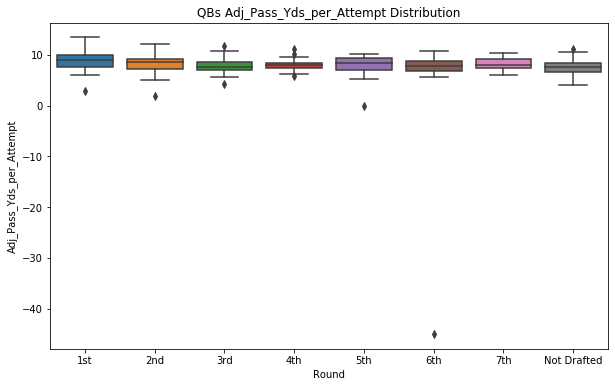

QBs Pass_TDs Summary:
count   332.00
mean     23.73
std       9.99
min       0.00
25%      17.00
50%      24.00
75%      30.00
max      60.00
Name: Pass_TDs, dtype: float64
----------------------------------------
QBs Pass_TDs by Round
             Pass_TDs
Round                
1st             29.17
2nd             24.00
3rd             23.80
4th             20.25
5th             21.83
6th             25.29
7th             24.72
Not Drafted     21.47


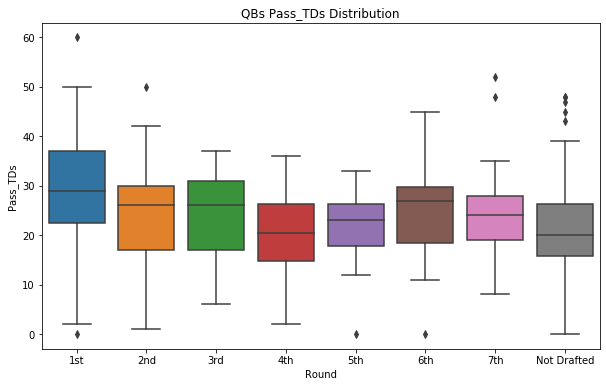

QBs Pass_Interceptions Summary:
count   332.00
mean      9.26
std       3.80
min       0.00
25%       7.00
50%       9.00
75%      12.00
max      22.00
Name: Pass_Interceptions, dtype: float64
----------------------------------------
QBs Pass_Interceptions by Round
             Pass_Interceptions
Round                          
1st                        9.02
2nd                        7.86
3rd                        9.48
4th                        8.89
5th                        8.58
6th                       10.18
7th                       10.36
Not Drafted                9.32


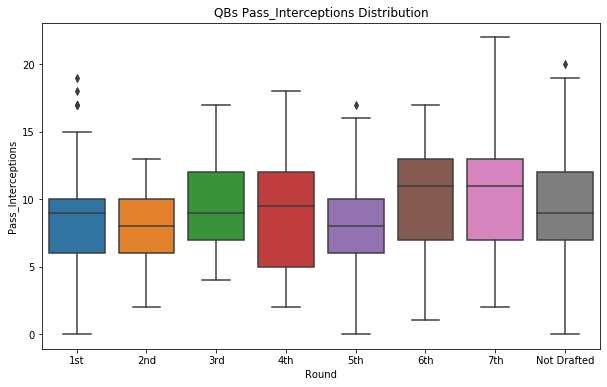

QBs Passer_Rating Summary:
count    332.00
mean     141.90
std       28.12
min     -200.00
25%      129.07
50%      143.30
75%      156.35
max      206.90
Name: Passer_Rating, dtype: float64
----------------------------------------
QBs Passer_Rating by Round
             Passer_Rating
Round                     
1st                 153.68
2nd                 142.98
3rd                 141.82
4th                 140.44
5th                 139.52
6th                 132.94
7th                 144.90
Not Drafted         138.56


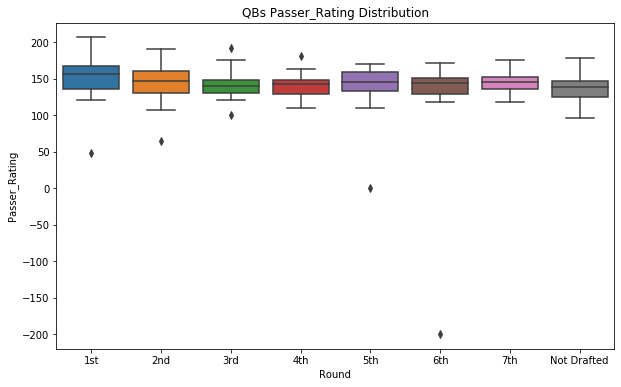

QBs CompletionsperGame Summary:
count   332.00
mean     19.53
std       5.82
min       0.00
25%      16.08
50%      19.04
75%      23.09
max      39.33
Name: CompletionsperGame, dtype: float64
----------------------------------------
QBs CompletionsperGame by Round
             CompletionsperGame
Round                          
1st                       20.88
2nd                       19.60
3rd                       21.22
4th                       18.82
5th                       17.30
6th                       20.91
7th                       20.17
Not Drafted               18.57


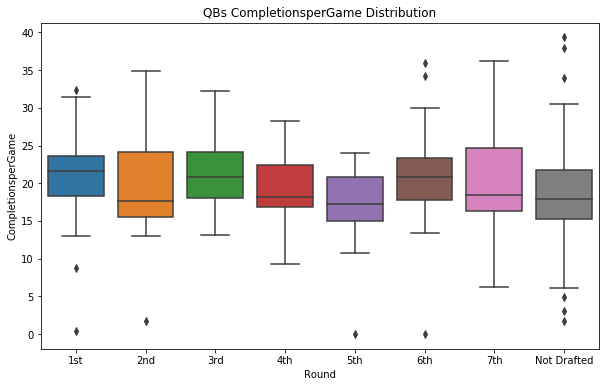

QBs Pass_AttemptsperGame Summary:
count   332.00
mean     31.37
std       8.21
min       0.00
25%      26.82
50%      31.15
75%      36.10
max      58.44
Name: Pass_AttemptsperGame, dtype: float64
----------------------------------------
QBs Pass_AttemptsperGame by Round
             Pass_AttemptsperGame
Round                            
1st                         32.29
2nd                         30.98
3rd                         33.87
4th                         30.79
5th                         28.13
6th                         33.55
7th                         32.25
Not Drafted                 30.42


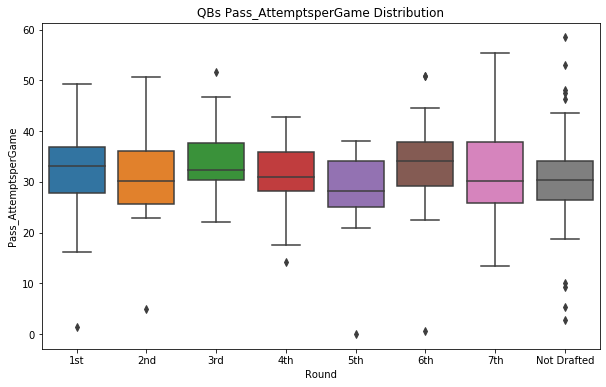

QBs Pass_YardsperGame Summary:
count   332.00
mean    247.89
std      68.46
min       0.00
25%     207.69
50%     245.79
75%     289.38
max     448.69
Name: Pass_YardsperGame, dtype: float64
----------------------------------------
QBs Pass_YardsperGame by Round
             Pass_YardsperGame
Round                         
1st                     272.49
2nd                     247.31
3rd                     261.12
4th                     244.33
5th                     222.82
6th                     260.38
7th                     259.39
Not Drafted             232.55


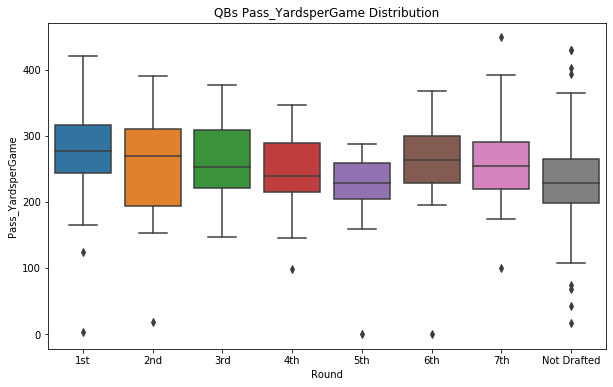

QBs Pass_TDsperGame Summary:
count   332.00
mean      1.92
std       0.73
min       0.00
25%       1.45
50%       1.91
75%       2.36
max       4.00
Name: Pass_TDsperGame, dtype: float64
----------------------------------------
QBs Pass_TDsperGame by Round
             Pass_TDsperGame
Round                       
1st                     2.27
2nd                     1.97
3rd                     1.95
4th                     1.67
5th                     1.81
6th                     2.08
7th                     1.96
Not Drafted             1.77


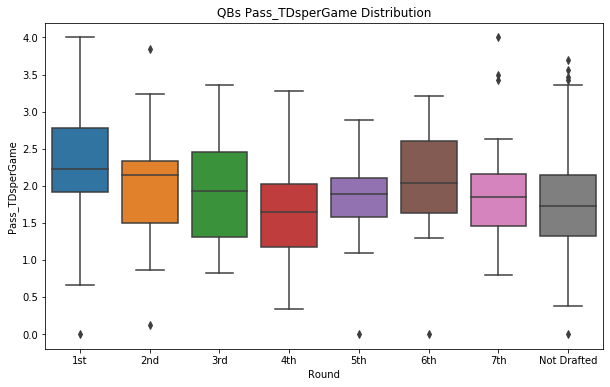

QBs Pass_InterceptionsperGame Summary:
count   332.00
mean      0.77
std       0.31
min       0.00
25%       0.54
50%       0.73
75%       1.00
max       1.70
Name: Pass_InterceptionsperGame, dtype: float64
----------------------------------------
QBs Pass_InterceptionsperGame by Round
             Pass_InterceptionsperGame
Round                                 
1st                               0.71
2nd                               0.68
3rd                               0.79
4th                               0.74
5th                               0.72
6th                               0.87
7th                               0.83
Not Drafted                       0.78


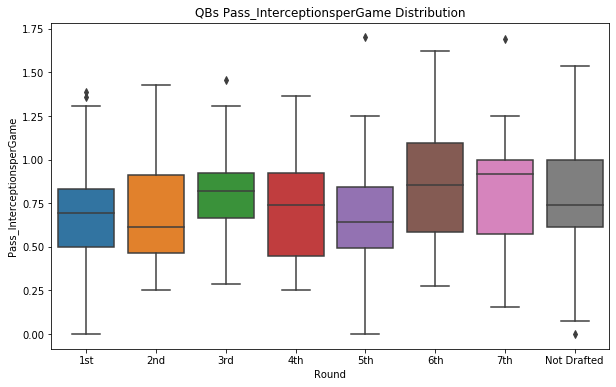

In [38]:
plot_stats('QBs', df, passing_stats)

In [39]:
for i in passing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', df, i)
    print('')
    print('*' * 40)

Passing_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   27.03     3.86 1.04    0.40
Residual 324.00 1201.10     3.71  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.7127 0.8076 -2.2053 0.7799  False
   1st         3rd  -0.3946    0.9 -1.7963 1.0072  False
   1st         4th  -0.6174 0.8428 -1.9654 0.7306  False
   1st         5th  -0.8496 0.5905 -2.2717 0.5726  False
   1st         6th  -0.6805  0.698 -1.9452 0.5843  False
   1st         7th   0.0854    0.9 -1.3163 1.4872  False
   1st Not Drafted  -0.4918 0.7241 -1.4311 0.4475  False
   2nd         3rd   0.3181    0.9 -1.4206 2.0568  False
   2nd         4th   0.0952    0.9 -1.6004 1.7909  False
   2nd         5th  -0.1369    0.9 -1.8921 1.6183  False
   2nd         6th   0.0322    0.9 -1.5981 1.6625  Fa

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1    group2    meandiff p-adj    lower      upper   reject
---------------------------------------------------------------
   1st         2nd -493.6408 0.4672 -1236.5996  249.3179  False
   1st         3rd -304.6732 0.8816 -1002.4219  393.0754  False
   1st         4th -522.6646 0.2564 -1193.6453   148.316  False
   1st         5th -769.6766 0.0224 -1477.5617  -61.7914   True
   1st         6th -306.0638 0.7919  -935.6155  323.4879  False
   1st         7th -208.8732    0.9  -906.6219  488.8754  False
   1st Not Drafted -665.9467  0.001 -1133.4873  -198.406   True
   2nd         3rd  188.9676    0.9  -676.5076 1054.4428  False
   2nd         4th  -29.0238    0.9  -873.0672  815.0195  False
   2nd         5th -276.0357    0.9 -1149.7036  597.6321  False
   2nd         6th   187.577    0.9  -623.9213  999.0753  False
   2nd         7th  284.7676    0.9  -580.7076 1150.2428  False
   2nd Not Drafted -172.3058    0.9  -86

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -1.1598    0.9  -4.098 1.7784  False
   1st         3rd   0.4631    0.9 -2.2963 3.2224  False
   1st         4th  -0.1241    0.9 -2.7776 2.5294  False
   1st         5th  -0.4336    0.9 -3.2331 2.3658  False
   1st         6th   1.1595 0.8289 -1.3301 3.6492  False
   1st         7th   1.3431 0.7909 -1.4163 4.1024  False
   1st Not Drafted    0.302    0.9  -1.547  2.151  False
   2nd         3rd   1.6229 0.8137 -1.7998 5.0455  False
   2nd         4th   1.0357    0.9 -2.3022 4.3736  False
   2nd         5th   0.7262    0.9 -2.7289 4.1813  False
   2nd         6th   2.3193 0.3522 -0.8899 5.5285  False
   2nd         7th   2.5029 0.3362 -0.9198 5.9255  False
   2nd Not Drafted   1.4618 0.7069 -1.2803 4.2039  False
   3rd         4th  -0.5871    0.9 -3.7688 2.5945  False
   3rd         5th  -0.8967    

             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   13.06     1.87 3.66    0.00
Residual 324.00  165.01     0.51  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.2985 0.6951 -0.8518  0.2547  False
   1st         3rd  -0.3282 0.5284 -0.8478  0.1914  False
   1st         4th  -0.5994 0.0071  -1.099 -0.0997   True
   1st         5th  -0.4679 0.1243  -0.995  0.0592  False
   1st         6th   -0.196    0.9 -0.6648  0.2728  False
   1st         7th  -0.3106 0.5897 -0.8302  0.2089  False
   1st Not Drafted  -0.5066  0.001 -0.8547 -0.1585   True
   2nd         3rd  -0.0297    0.9 -0.6741  0.6148  False
   2nd         4th  -0.3008 0.8055 -0.9293  0.3277  False
   2nd         5th  -0.1694    0.9 -0.8199  0.4812  False
   2nd         6th   0.1025    0.9 -0.5017  0.7068  False
   2nd         7th  -0.0121    0.9 -0.6565  0.632

### College Stats - Rushing & Receiving

In [40]:
rushing_stats = ['Rush_Rec_Games', 'Rush_Attempts', 'Rush_Yds', 'Rush_Yds_per_Attempt', 'Rush_TDs', 
                 'Receptions', 'Rec_Yds', 'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 'Scrimmage_Yds',
                 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs', 'Rush_AttemptsperGame', 'Rush_YdsperGame', 
                 'Rush_TDsperGame', 'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                 'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame', 'Scrimmage_TDsperGame']

QBs Rush_Rec_Games Summary:
count   332.00
mean     12.05
std       1.93
min       0.00
25%      11.00
50%      13.00
75%      13.00
max      15.00
Name: Rush_Rec_Games, dtype: float64
----------------------------------------
QBs Rush_Rec_Games by Round
             Rush_Rec_Games
Round                      
1st                   12.47
2nd                   11.76
3rd                   12.08
4th                   11.86
5th                   11.62
6th                   11.79
7th                   12.56
Not Drafted           11.98


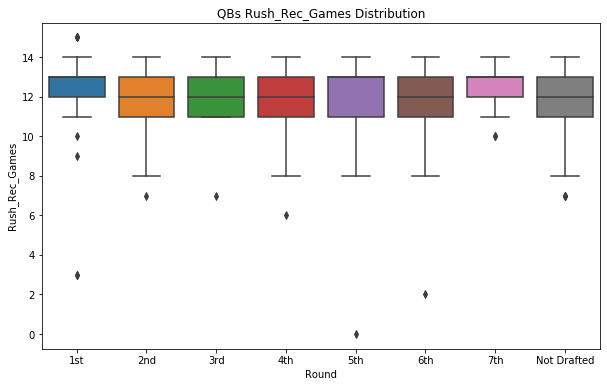

QBs Rush_Attempts Summary:
count   332.00
mean     78.97
std      47.90
min       0.00
25%      47.00
50%      68.00
75%     100.25
max     292.00
Name: Rush_Attempts, dtype: float64
----------------------------------------
QBs Rush_Attempts by Round
             Rush_Attempts
Round                     
1st                  88.49
2nd                  89.86
3rd                  68.72
4th                  72.71
5th                  67.71
6th                  69.35
7th                  83.56
Not Drafted          80.03


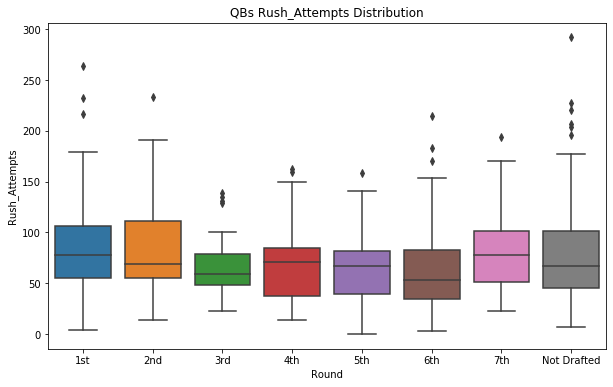

QBs Rush_Yds Summary:
count    332.00
mean     177.77
std      325.29
min     -306.00
25%      -39.25
50%       75.00
75%      311.25
max     1920.00
Name: Rush_Yds, dtype: float64
----------------------------------------
QBs Rush_Yds by Round
             Rush_Yds
Round                
1st            263.61
2nd            302.95
3rd             13.28
4th            127.64
5th            158.83
6th            109.50
7th            201.28
Not Drafted    177.86


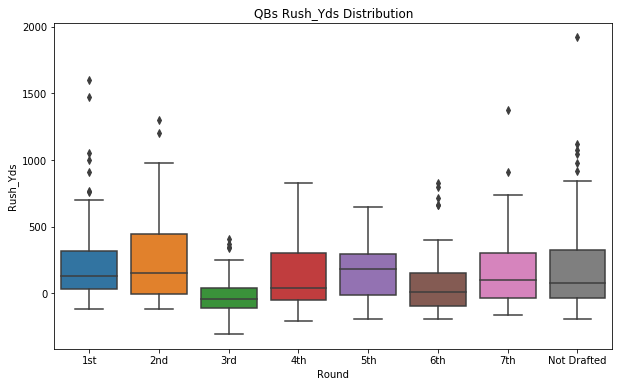

QBs Rush_Yds_per_Attempt Summary:
count   332.00
mean      1.09
std       2.81
min      -7.90
25%      -1.00
50%       1.10
75%       3.23
max       7.20
Name: Rush_Yds_per_Attempt, dtype: float64
----------------------------------------
QBs Rush_Yds_per_Attempt by Round
             Rush_Yds_per_Attempt
Round                            
1st                          1.88
2nd                          2.13
3rd                         -0.64
4th                          0.55
5th                          1.61
6th                          0.33
7th                          1.15
Not Drafted                  1.11


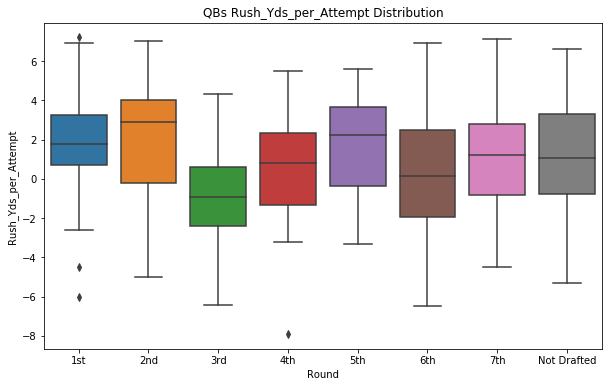

QBs Rush_TDs Summary:
count   332.00
mean      3.98
std       4.19
min       0.00
25%       1.00
50%       3.00
75%       6.00
max      23.00
Name: Rush_TDs, dtype: float64
----------------------------------------
QBs Rush_TDs by Round
             Rush_TDs
Round                
1st              5.08
2nd              5.29
3rd              2.96
4th              3.43
5th              3.62
6th              3.65
7th              3.08
Not Drafted      3.91


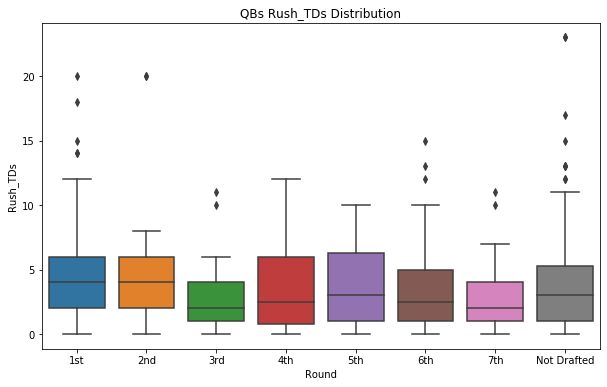

QBs Receptions Summary:
count   332.00
mean      0.30
std       0.85
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      12.00
Name: Receptions, dtype: float64
----------------------------------------
QBs Receptions by Round
             Receptions
Round                  
1st                0.37
2nd                0.33
3rd                0.28
4th                0.21
5th                0.29
6th                0.18
7th                0.16
Not Drafted        0.34


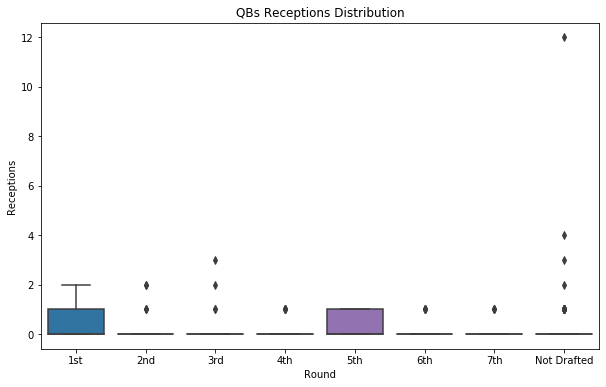

QBs Rec_Yds Summary:
count   332.00
mean      2.96
std      10.85
min     -16.00
25%       0.00
50%       0.00
75%       0.00
max     121.00
Name: Rec_Yds, dtype: float64
----------------------------------------
QBs Rec_Yds by Round
             Rec_Yds
Round               
1st             4.22
2nd             2.00
3rd             5.24
4th             1.43
5th             1.58
6th             3.62
7th             3.80
Not Drafted     2.28


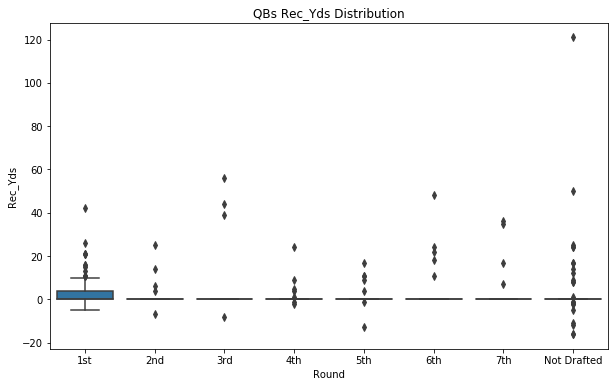

QBs Rec_Yds_per_Reception Summary:
count   332.00
mean      2.06
std       6.96
min     -16.00
25%       0.00
50%       0.00
75%       0.00
max      48.00
Name: Rec_Yds_per_Reception, dtype: float64
----------------------------------------
QBs Rec_Yds_per_Reception by Round
             Rec_Yds_per_Reception
Round                             
1st                           3.32
2nd                           1.26
3rd                           2.87
4th                           1.25
5th                           1.58
6th                           3.62
7th                           3.80
Not Drafted                   0.84


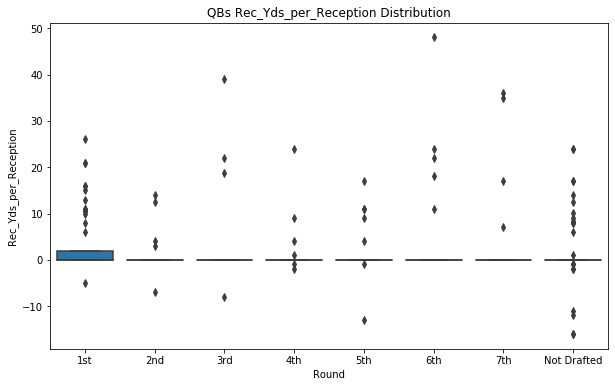

QBs Rec_TDs Summary:
count   332.00
mean      0.06
std       0.23
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Rec_TDs, dtype: float64
----------------------------------------
QBs Rec_TDs by Round
             Rec_TDs
Round               
1st             0.07
2nd             0.14
3rd             0.08
4th             0.07
5th             0.08
6th             0.03
7th             0.08
Not Drafted     0.03


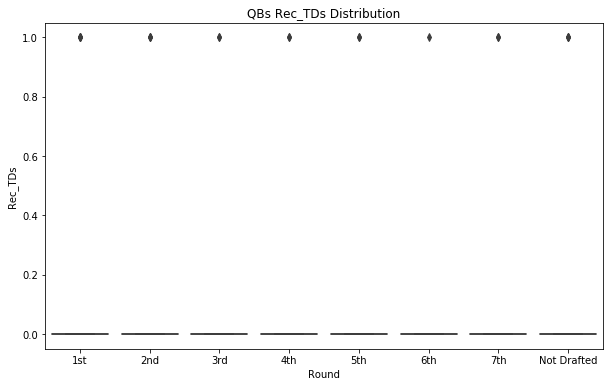

QBs Plays_from_Scrimmage Summary:
count   332.00
mean     79.27
std      48.00
min       0.00
25%      47.75
50%      68.50
75%     101.00
max     293.00
Name: Plays_from_Scrimmage, dtype: float64
----------------------------------------
QBs Plays_from_Scrimmage by Round
             Plays_from_Scrimmage
Round                            
1st                         88.86
2nd                         90.19
3rd                         69.00
4th                         72.93
5th                         68.00
6th                         69.53
7th                         83.72
Not Drafted                 80.37


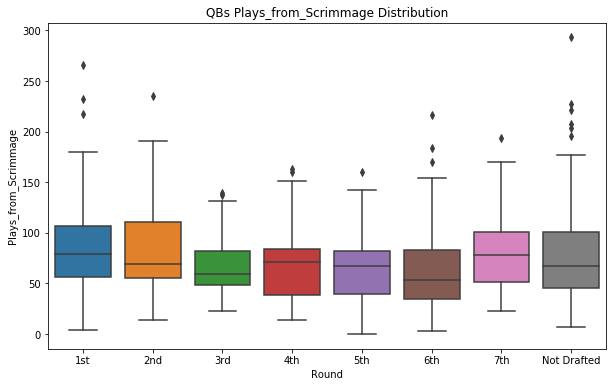

QBs Scrimmage_Yds Summary:
count    332.00
mean     180.73
std      327.51
min     -306.00
25%      -39.00
50%       75.50
75%      317.50
max     1937.00
Name: Scrimmage_Yds, dtype: float64
----------------------------------------
QBs Scrimmage_Yds by Round
             Scrimmage_Yds
Round                     
1st                 267.83
2nd                 304.95
3rd                  18.52
4th                 129.07
5th                 160.42
6th                 113.12
7th                 205.08
Not Drafted         180.14


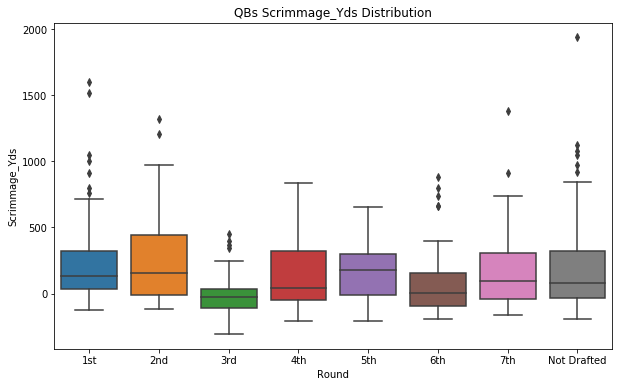

QBs Scrimmage_Yds_per_Attempt Summary:
count   332.00
mean      1.12
std       2.82
min      -7.90
25%      -0.93
50%       1.10
75%       3.30
max       7.20
Name: Scrimmage_Yds_per_Attempt, dtype: float64
----------------------------------------
QBs Scrimmage_Yds_per_Attempt by Round
             Scrimmage_Yds_per_Attempt
Round                                 
1st                               1.92
2nd                               2.13
3rd                              -0.59
4th                               0.56
5th                               1.61
6th                               0.36
7th                               1.22
Not Drafted                       1.12


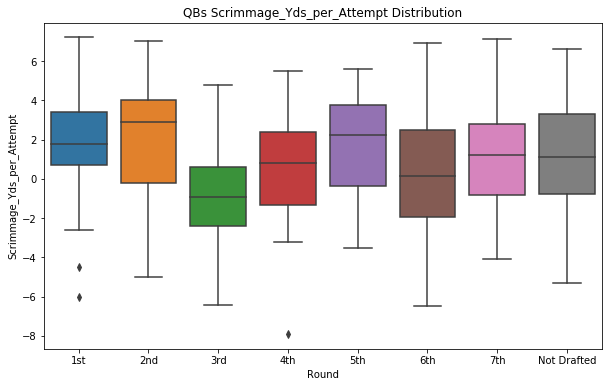

QBs Scrimmage_TDs Summary:
count   332.00
mean      4.04
std       4.25
min       0.00
25%       1.00
50%       3.00
75%       6.00
max      24.00
Name: Scrimmage_TDs, dtype: float64
----------------------------------------
QBs Scrimmage_TDs by Round
             Scrimmage_TDs
Round                     
1st                   5.15
2nd                   5.43
3rd                   3.04
4th                   3.50
5th                   3.71
6th                   3.68
7th                   3.16
Not Drafted           3.93


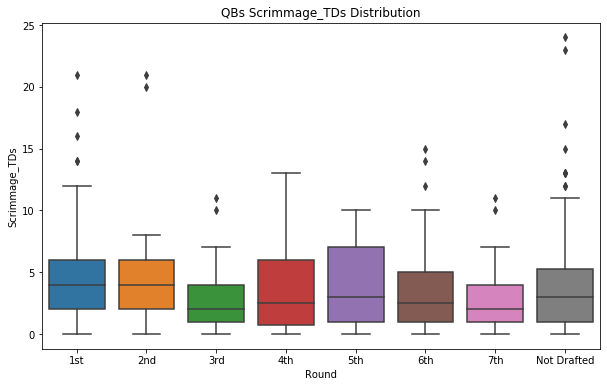

QBs Rush_AttemptsperGame Summary:
count   332.00
mean      6.45
std       3.64
min       0.00
25%       3.98
50%       5.52
75%       8.56
max      20.86
Name: Rush_AttemptsperGame, dtype: float64
----------------------------------------
QBs Rush_AttemptsperGame by Round
             Rush_AttemptsperGame
Round                            
1st                          6.91
2nd                          7.48
3rd                          5.70
4th                          6.09
5th                          5.68
6th                          5.59
7th                          6.72
Not Drafted                  6.64


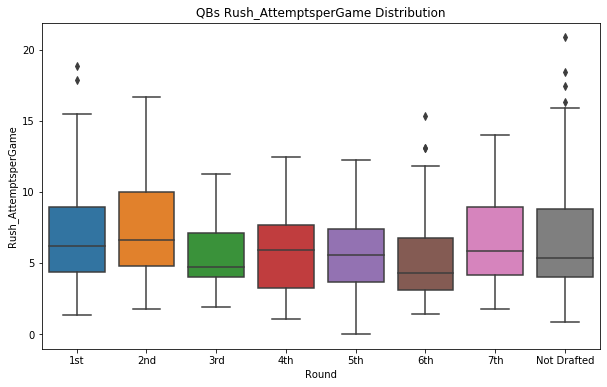

QBs Rush_YdsperGame Summary:
count   332.00
mean     14.16
std      25.38
min     -25.50
25%      -3.35
50%       6.12
75%      24.89
max     137.14
Name: Rush_YdsperGame, dtype: float64
----------------------------------------
QBs Rush_YdsperGame by Round
             Rush_YdsperGame
Round                       
1st                    20.09
2nd                    24.29
3rd                     0.84
4th                    10.66
5th                    13.82
6th                     8.45
7th                    16.02
Not Drafted            14.37


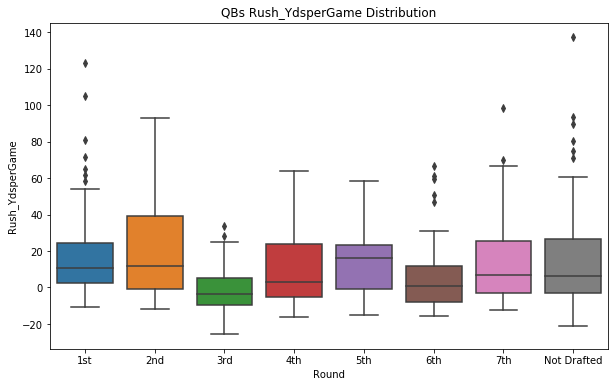

QBs Rush_TDsperGame Summary:
count   332.00
mean      0.32
std       0.32
min       0.00
25%       0.08
50%       0.23
75%       0.46
max       1.77
Name: Rush_TDsperGame, dtype: float64
----------------------------------------
QBs Rush_TDsperGame by Round
             Rush_TDsperGame
Round                       
1st                     0.39
2nd                     0.42
3rd                     0.24
4th                     0.29
5th                     0.30
6th                     0.29
7th                     0.24
Not Drafted             0.32


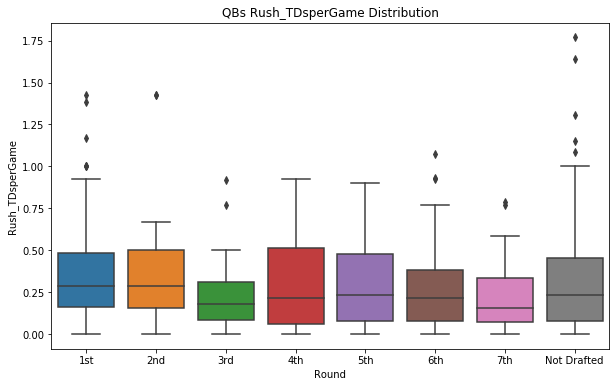

QBs ReceptionsperGame Summary:
count   332.00
mean      0.02
std       0.07
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.09
Name: ReceptionsperGame, dtype: float64
----------------------------------------
QBs ReceptionsperGame by Round
             ReceptionsperGame
Round                         
1st                       0.03
2nd                       0.03
3rd                       0.02
4th                       0.02
5th                       0.02
6th                       0.01
7th                       0.01
Not Drafted               0.03


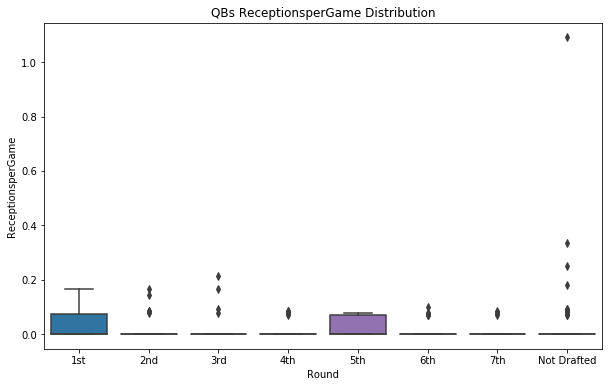

QBs Rec_YdsperGame Summary:
count   332.00
mean      0.23
std       0.90
min      -1.23
25%       0.00
50%       0.00
75%       0.00
max      11.00
Name: Rec_YdsperGame, dtype: float64
----------------------------------------
QBs Rec_YdsperGame by Round
             Rec_YdsperGame
Round                      
1st                    0.32
2nd                    0.15
3rd                    0.40
4th                    0.11
5th                    0.12
6th                    0.28
7th                    0.30
Not Drafted            0.19


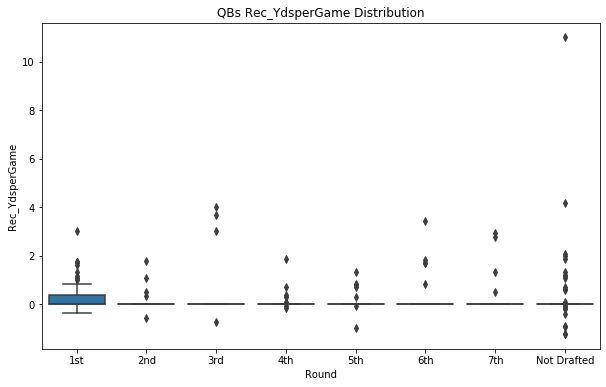

QBs Rec_TDsperGame Summary:
count   332.00
mean      0.00
std       0.02
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.09
Name: Rec_TDsperGame, dtype: float64
----------------------------------------
QBs Rec_TDsperGame by Round
             Rec_TDsperGame
Round                      
1st                    0.00
2nd                    0.01
3rd                    0.01
4th                    0.01
5th                    0.01
6th                    0.00
7th                    0.01
Not Drafted            0.00


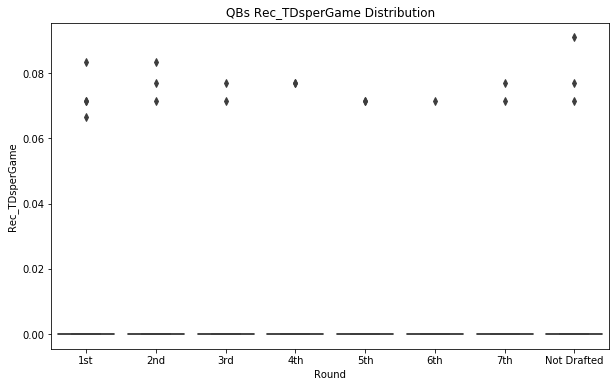

QBs Plays_from_ScrimmageperGame Summary:
count   332.00
mean      6.48
std       3.65
min       0.00
25%       4.00
50%       5.52
75%       8.62
max      20.93
Name: Plays_from_ScrimmageperGame, dtype: float64
----------------------------------------
QBs Plays_from_ScrimmageperGame by Round
             Plays_from_ScrimmageperGame
Round                                   
1st                                 6.94
2nd                                 7.51
3rd                                 5.72
4th                                 6.11
5th                                 5.70
6th                                 5.60
7th                                 6.74
Not Drafted                         6.67


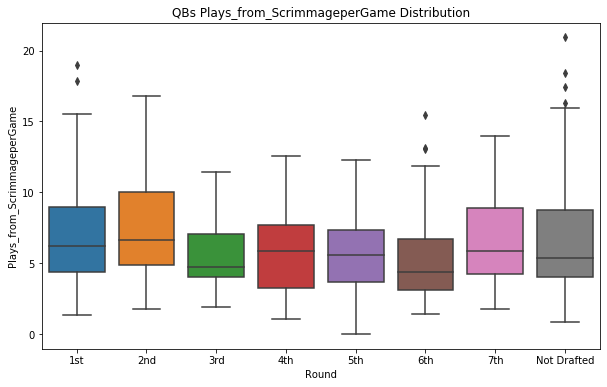

QBs Scrimmage_YdsperGame Summary:
count   332.00
mean     14.39
std      25.54
min     -25.50
25%      -3.08
50%       6.21
75%      25.33
max     138.36
Name: Scrimmage_YdsperGame, dtype: float64
----------------------------------------
QBs Scrimmage_YdsperGame by Round
             Scrimmage_YdsperGame
Round                            
1st                         20.41
2nd                         24.43
3rd                          1.23
4th                         10.77
5th                         13.94
6th                          8.73
7th                         16.32
Not Drafted                 14.56


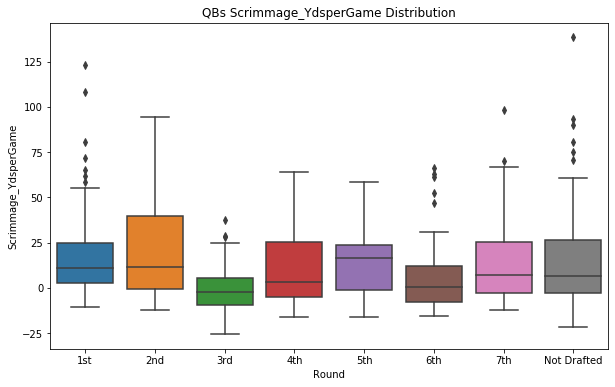

QBs Scrimmage_TDsperGame Summary:
count   332.00
mean      0.32
std       0.32
min       0.00
25%       0.08
50%       0.23
75%       0.46
max       1.77
Name: Scrimmage_TDsperGame, dtype: float64
----------------------------------------
QBs Scrimmage_TDsperGame by Round
             Scrimmage_TDsperGame
Round                            
1st                          0.40
2nd                          0.43
3rd                          0.24
4th                          0.29
5th                          0.31
6th                          0.29
7th                          0.25
Not Drafted                  0.32


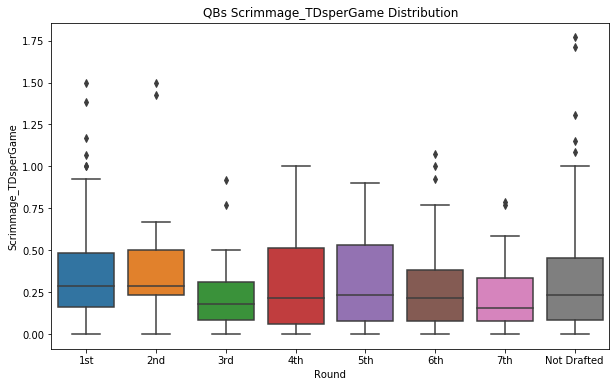

In [41]:
plot_stats('QBs', df, rushing_stats)

In [526]:
for i in rushing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', QB_df, i)
    print('')
    print('*' * 40)

Rush_Rec_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   27.03     3.86 1.04    0.40
Residual 324.00 1201.10     3.71  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.7127 0.8076 -2.2053 0.7799  False
   1st         3rd  -0.3946    0.9 -1.7963 1.0072  False
   1st         4th  -0.6174 0.8428 -1.9654 0.7306  False
   1st         5th  -0.8496 0.5905 -2.2717 0.5726  False
   1st         6th  -0.6805  0.698 -1.9452 0.5843  False
   1st         7th   0.0854    0.9 -1.3163 1.4872  False
   1st Not Drafted  -0.4918 0.7241 -1.4311 0.4475  False
   2nd         3rd   0.3181    0.9 -1.4206 2.0568  False
   2nd         4th   0.0952    0.9 -1.6004 1.7909  False
   2nd         5th  -0.1369    0.9 -1.8921 1.6183  False
   2nd         6th   0.0322    0.9 -1.5981 1.6625  F

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd    0.201    0.9 -3.0305 3.4324  False
   1st         3rd  -2.1247 0.3962 -5.1596 0.9101  False
   1st         4th  -1.6562 0.6446 -4.5746 1.2622  False
   1st         5th  -1.4597 0.8137 -4.5387 1.6192  False
   1st         6th  -1.4377 0.7215 -4.1759 1.3005  False
   1st         7th  -2.0047 0.4747 -5.0396 1.0301  False
   1st Not Drafted  -1.1796 0.6219 -3.2131  0.854  False
   2nd         3rd  -2.3257 0.5535 -6.0901 1.4386  False
   2nd         4th  -1.8571 0.7562 -5.5283  1.814  False
   2nd         5th  -1.6607 0.8809 -5.4607 2.1393  False
   2nd         6th  -1.6387 0.8316 -5.1682 1.8909  False
   2nd         7th  -2.2057 0.6112 -5.9701 1.5586  False
   2nd Not Drafted  -1.3805 0.8433 -4.3964 1.6353  False
   3rd         4th   0.4686    0.9 -3.0307 3.9679  False
   3rd         5th    0.665    

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd   1.3261    0.9 -35.8243 38.4764  False
   1st         3rd -19.8644 0.6413 -54.7541 15.0253  False
   1st         4th -15.9358 0.8122 -49.4871 17.6154  False
   1st         5th -20.8644 0.6049  -56.261 14.5322  False
   1st         6th  -19.335   0.56 -50.8146 12.1446  False
   1st         7th  -5.1444    0.9 -40.0341 29.7453  False
   1st Not Drafted  -8.4937    0.9 -31.8723 14.8848  False
   2nd         3rd -21.1905 0.7856 -64.4671 22.0861  False
   2nd         4th -17.2619    0.9 -59.4668  24.943  False
   2nd         5th -22.1905 0.7524 -65.8767 21.4958  False
   2nd         6th -20.6611 0.7502 -61.2386 19.9165  False
   2nd         7th  -6.4705    0.9 -49.7471 36.8061  False
   2nd Not Drafted  -9.8198    0.9 -44.4915 24.8519  False
   3rd         4th   3.9286    0.9 -36.3007 44.1579  Fal

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.5717    0.9 -2.2502 3.3936  False
   1st         3rd  -1.2162 0.8412 -3.8664  1.434  False
   1st         4th  -0.8237    0.9 -3.3723 1.7248  False
   1st         5th  -1.2308 0.8433 -3.9196 1.4579  False
   1st         6th  -1.3263 0.6679 -3.7174 1.0649  False
   1st         7th  -0.1898    0.9   -2.84 2.4604  False
   1st Not Drafted  -0.2759    0.9 -2.0517    1.5  False
   2nd         3rd  -1.7879 0.6874 -5.0752 1.4994  False
   2nd         4th  -1.3954 0.8841 -4.6013 1.8105  False
   2nd         5th  -1.8025 0.6886 -5.1209 1.5159  False
   2nd         6th  -1.8979 0.5572 -4.9802 1.1843  False
   2nd         7th  -0.7615    0.9 -4.0488 2.5258  False
   2nd Not Drafted  -0.8476    0.9 -3.4812 1.7861  False
   3rd         4th   0.3925    0.9 -2.6633 3.4483  False
   3rd         5th  -0.0146    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.5688    0.9 -2.2577 3.3954  False
   1st         3rd  -1.2235 0.8377  -3.878 1.4311  False
   1st         4th  -0.8362    0.9 -3.3889 1.7166  False
   1st         5th  -1.2381 0.8398 -3.9312 1.4551  False
   1st         6th  -1.3417 0.6579 -3.7368 1.0534  False
   1st         7th  -0.2067    0.9 -2.8612 2.4479  False
   1st Not Drafted  -0.2767    0.9 -2.0554  1.502  False
   2nd         3rd  -1.7923 0.6866  -5.085 1.5004  False
   2nd         4th   -1.405 0.8799 -4.6161 1.8061  False
   2nd         5th  -1.8069 0.6879 -5.1307 1.5169  False
   2nd         6th  -1.9105 0.5517 -4.9978 1.1768  False
   2nd         7th  -0.7755    0.9 -4.0681 2.5172  False
   2nd Not Drafted  -0.8455    0.9 -3.4835 1.7924  False
   3rd         4th   0.3873    0.9 -2.6735 3.4481  False
   3rd         5th  -0.0146    

### College Stats - Defense

In [527]:
defense_stats = ['Defense_Games', 'Solo_Tackles', 'Assisted_Tackles', 'Ttl_Tackles', 'Loss', 'Sacks', 
                 'Defensive_Interceptions', 'Def_Int_Yds', 'Yds_per_Int', 'Pick_6', 'Defended_Passes', 
                 'Recovered_Fumbles', 'Rec_Fumbles_Yds', 'Fumbles_Returned_TD', 'Forced_Fumbles', 
                 'Solo_TacklesperGame', 'Assisted_TacklesperGame', 'Ttl_TacklesperGame', 'LossperGame', 
                 'SacksperGame', 'Defensive_InterceptionsperGame', 'Def_Int_YdsperGame', 'Pick_6perGame', 
                 'Defended_PassesperGame', 'Recovered_FumblesperGame', 'Rec_Fumbles_YdsperGame', 
                 'Fumbles_Returned_TDperGame', 'Forced_FumblesperGame']

QBs Defense_Games Summary:
count   332.00
mean      7.11
std       6.25
min       0.00
25%       0.00
50%      11.00
75%      13.00
max      15.00
Name: Defense_Games, dtype: float64
----------------------------------------
QBs Defense_Games by Round
             Defense_Games
Round                     
1st                   8.39
2nd                   9.38
3rd                   6.64
4th                   4.29
5th                   6.83
6th                   6.85
7th                   4.56
Not Drafted           7.52


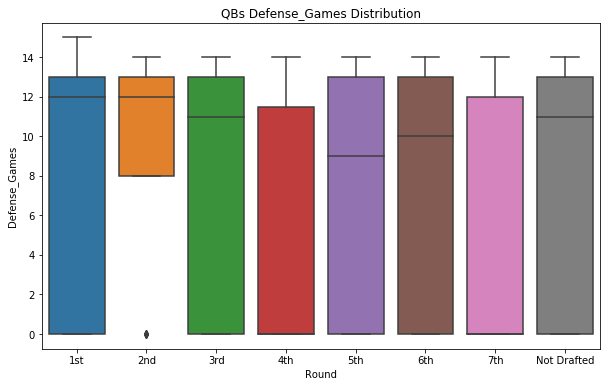

QBs Solo_Tackles Summary:
count   332.00
mean      0.47
std       1.32
min       0.00
25%       0.00
50%       0.00
75%       1.00
max      21.00
Name: Solo_Tackles, dtype: float64
----------------------------------------
QBs Solo_Tackles by Round
             Solo_Tackles
Round                    
1st                  0.51
2nd                  0.62
3rd                  0.28
4th                  0.11
5th                  1.08
6th                  0.47
7th                  0.36
Not Drafted          0.45


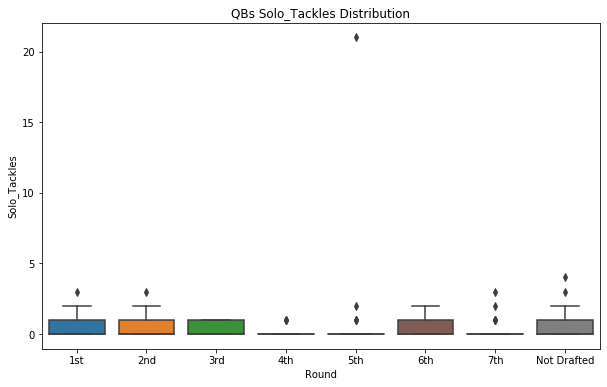

QBs Assisted_Tackles Summary:
count   332.00
mean      0.17
std       1.67
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      30.00
Name: Assisted_Tackles, dtype: float64
----------------------------------------
QBs Assisted_Tackles by Round
             Assisted_Tackles
Round                        
1st                      0.07
2nd                      0.05
3rd                      0.04
4th                      0.00
5th                      1.29
6th                      0.12
7th                      0.08
Not Drafted              0.12


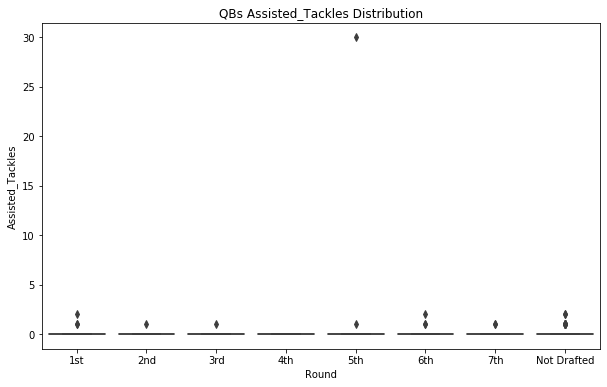

QBs Ttl_Tackles Summary:
count   332.00
mean      0.64
std       2.88
min       0.00
25%       0.00
50%       0.00
75%       1.00
max      51.00
Name: Ttl_Tackles, dtype: float64
----------------------------------------
QBs Ttl_Tackles by Round
             Ttl_Tackles
Round                   
1st                 0.58
2nd                 0.67
3rd                 0.32
4th                 0.11
5th                 2.38
6th                 0.59
7th                 0.44
Not Drafted         0.57


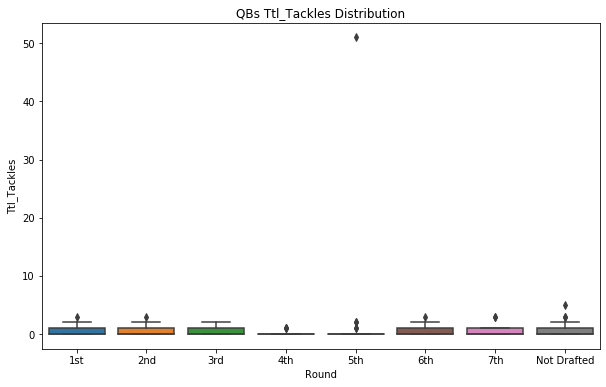

QBs Loss Summary:
count   332.00
mean      0.01
std       0.20
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       3.50
Name: Loss, dtype: float64
----------------------------------------
QBs Loss by Round
             Loss
Round            
1st          0.00
2nd          0.00
3rd          0.00
4th          0.00
5th          0.15
6th          0.00
7th          0.00
Not Drafted  0.01


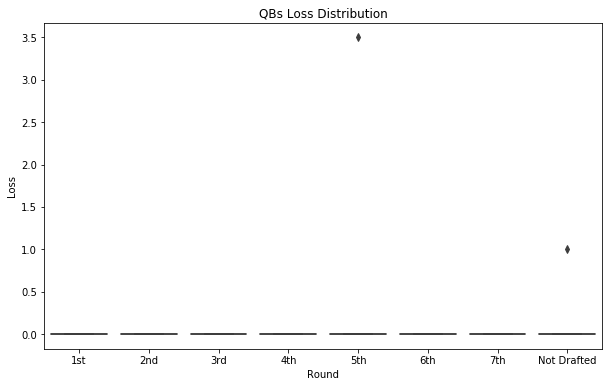

QBs Sacks Summary:
count   332.00
mean      0.00
std       0.05
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Sacks, dtype: float64
----------------------------------------
QBs Sacks by Round
             Sacks
Round             
1st           0.00
2nd           0.00
3rd           0.00
4th           0.00
5th           0.04
6th           0.00
7th           0.00
Not Drafted   0.00


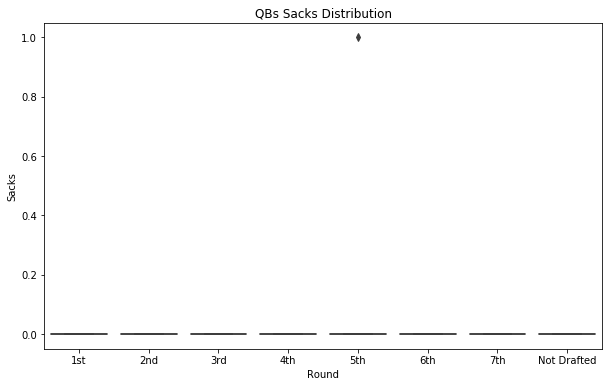

QBs Defensive_Interceptions Summary:
count   332.00
mean      0.00
std       0.05
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Defensive_Interceptions, dtype: float64
----------------------------------------
QBs Defensive_Interceptions by Round
             Defensive_Interceptions
Round                               
1st                             0.02
2nd                             0.00
3rd                             0.00
4th                             0.00
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.00


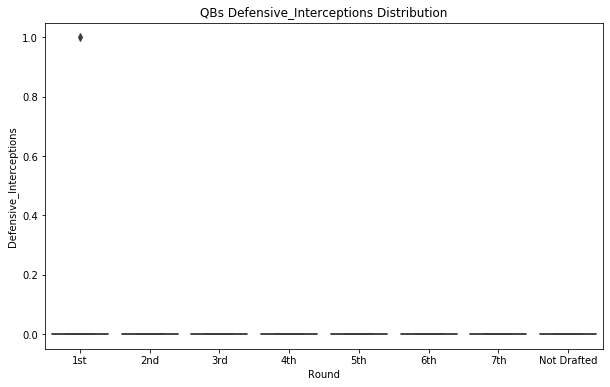

QBs Def_Int_Yds Summary:
count   332.00
mean      0.06
std       1.15
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      21.00
Name: Def_Int_Yds, dtype: float64
----------------------------------------
QBs Def_Int_Yds by Round
             Def_Int_Yds
Round                   
1st                 0.36
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


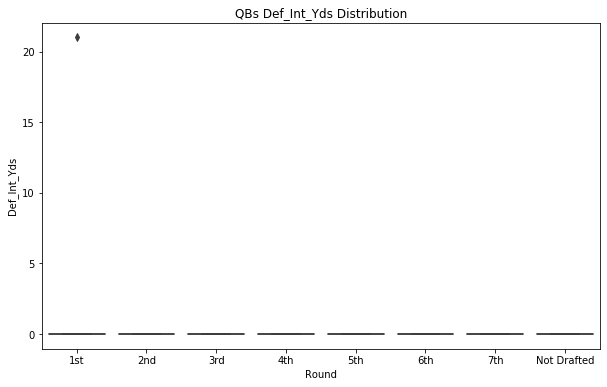

QBs Yds_per_Int Summary:
count   332.00
mean      0.06
std       1.15
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      21.00
Name: Yds_per_Int, dtype: float64
----------------------------------------
QBs Yds_per_Int by Round
             Yds_per_Int
Round                   
1st                 0.36
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


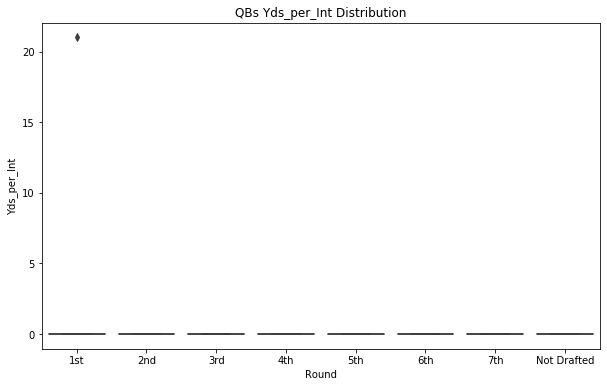

QBs Pick_6 Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pick_6, dtype: float64
----------------------------------------
QBs Pick_6 by Round
             Pick_6
Round              
1st            0.00
2nd            0.00
3rd            0.00
4th            0.00
5th            0.00
6th            0.00
7th            0.00
Not Drafted    0.00


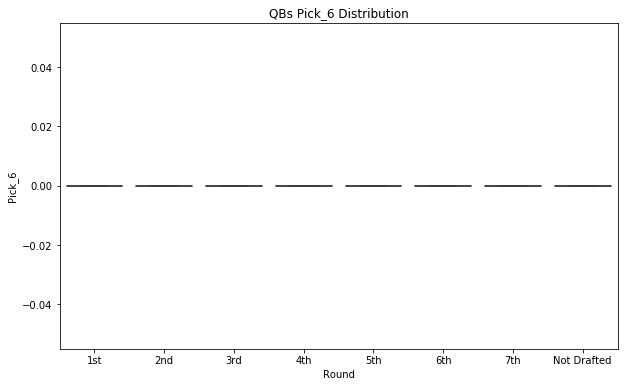

QBs Defended_Passes Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Defended_Passes, dtype: float64
----------------------------------------
QBs Defended_Passes by Round
             Defended_Passes
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


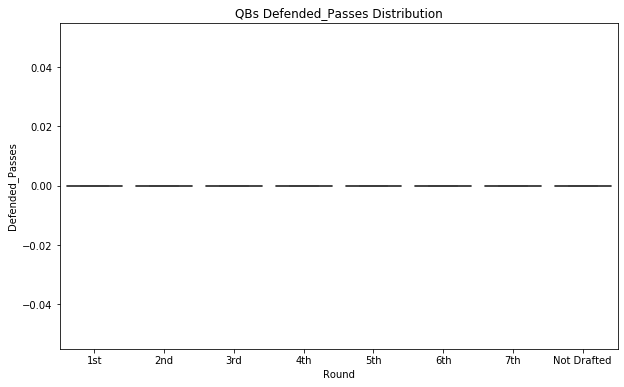

QBs Recovered_Fumbles Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Recovered_Fumbles, dtype: float64
----------------------------------------
QBs Recovered_Fumbles by Round
             Recovered_Fumbles
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


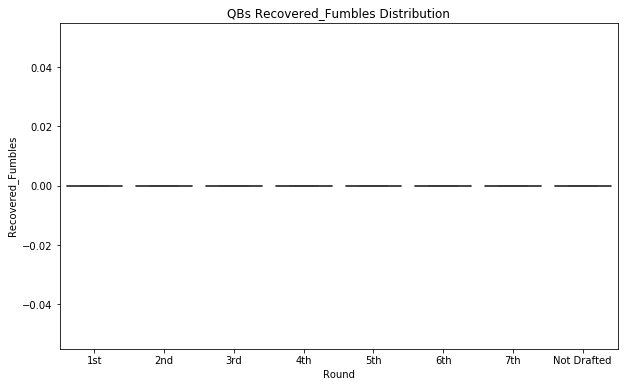

QBs Rec_Fumbles_Yds Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Rec_Fumbles_Yds, dtype: float64
----------------------------------------
QBs Rec_Fumbles_Yds by Round
             Rec_Fumbles_Yds
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


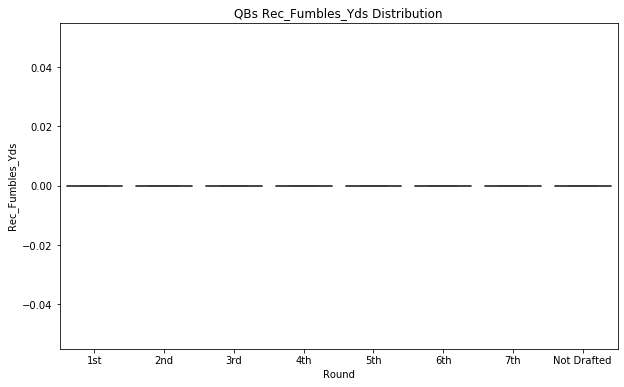

QBs Fumbles_Returned_TD Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Fumbles_Returned_TD, dtype: float64
----------------------------------------
QBs Fumbles_Returned_TD by Round
             Fumbles_Returned_TD
Round                           
1st                         0.00
2nd                         0.00
3rd                         0.00
4th                         0.00
5th                         0.00
6th                         0.00
7th                         0.00
Not Drafted                 0.00


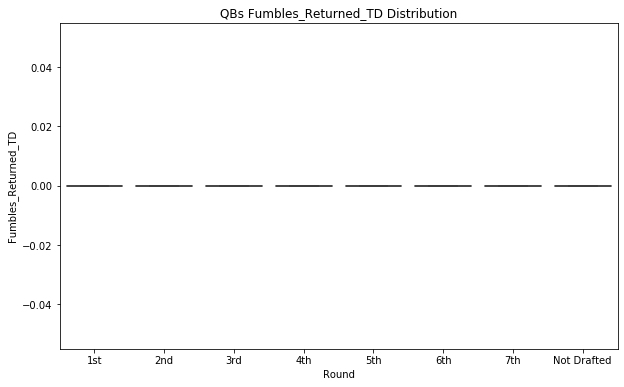

QBs Forced_Fumbles Summary:
count   332.00
mean      0.02
std       0.15
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.00
Name: Forced_Fumbles, dtype: float64
----------------------------------------
QBs Forced_Fumbles by Round
             Forced_Fumbles
Round                      
1st                    0.03
2nd                    0.10
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.02


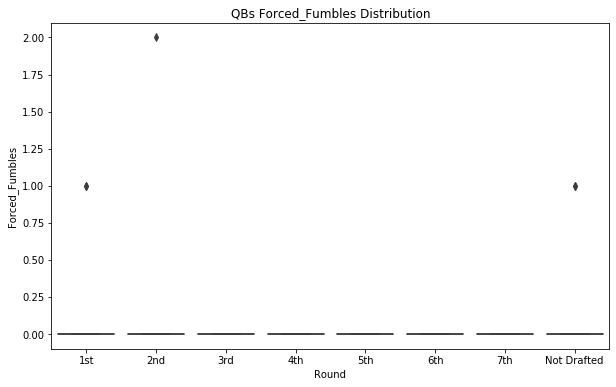

QBs Solo_TacklesperGame Summary:
count   332.00
mean      0.04
std       0.15
min       0.00
25%       0.00
50%       0.00
75%       0.08
max       2.62
Name: Solo_TacklesperGame, dtype: float64
----------------------------------------
QBs Solo_TacklesperGame by Round
             Solo_TacklesperGame
Round                           
1st                         0.04
2nd                         0.05
3rd                         0.02
4th                         0.01
5th                         0.13
6th                         0.04
7th                         0.03
Not Drafted                 0.04


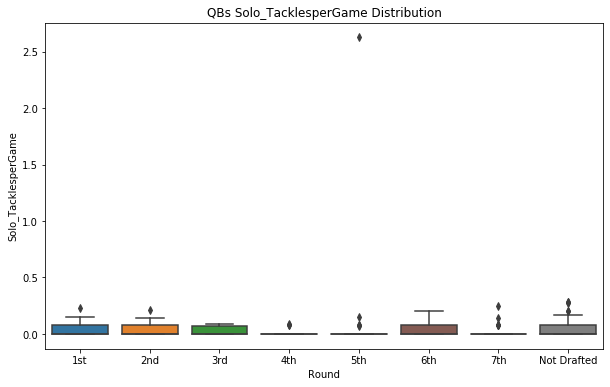

QBs Assisted_TacklesperGame Summary:
count   332.00
mean      0.02
std       0.21
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       3.75
Name: Assisted_TacklesperGame, dtype: float64
----------------------------------------
QBs Assisted_TacklesperGame by Round
             Assisted_TacklesperGame
Round                               
1st                             0.01
2nd                             0.00
3rd                             0.00
4th                             0.00
5th                             0.16
6th                             0.01
7th                             0.01
Not Drafted                     0.01


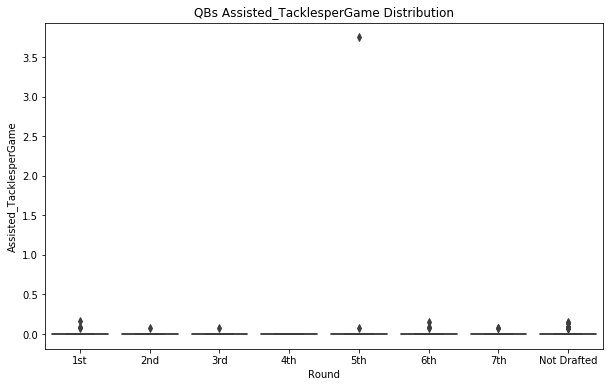

QBs Ttl_TacklesperGame Summary:
count   332.00
mean      0.06
std       0.35
min       0.00
25%       0.00
50%       0.00
75%       0.08
max       6.38
Name: Ttl_TacklesperGame, dtype: float64
----------------------------------------
QBs Ttl_TacklesperGame by Round
             Ttl_TacklesperGame
Round                          
1st                        0.04
2nd                        0.05
3rd                        0.02
4th                        0.01
5th                        0.28
6th                        0.05
7th                        0.03
Not Drafted                0.05


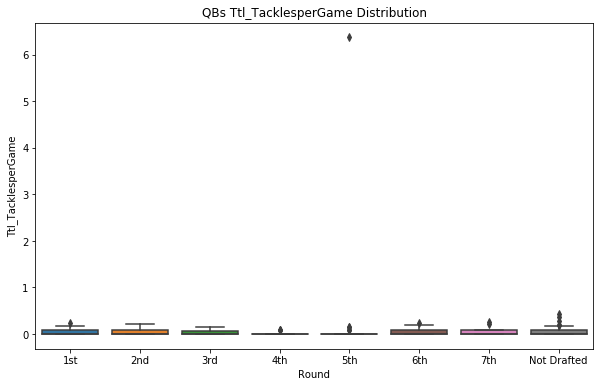

QBs LossperGame Summary:
count   332.00
mean      0.00
std       0.03
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.44
Name: LossperGame, dtype: float64
----------------------------------------
QBs LossperGame by Round
             LossperGame
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.02
6th                 0.00
7th                 0.00
Not Drafted         0.00


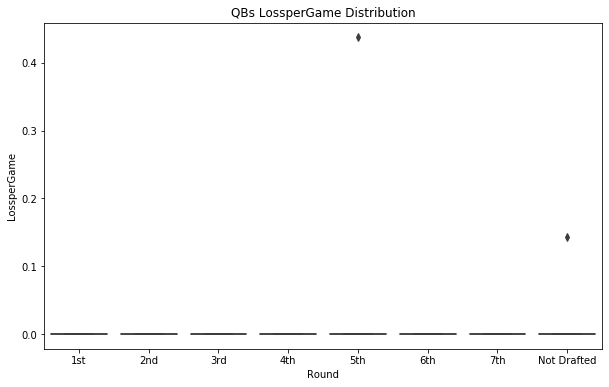

QBs SacksperGame Summary:
count   332.00
mean      0.00
std       0.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.12
Name: SacksperGame, dtype: float64
----------------------------------------
QBs SacksperGame by Round
             SacksperGame
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  0.00
5th                  0.01
6th                  0.00
7th                  0.00
Not Drafted          0.00


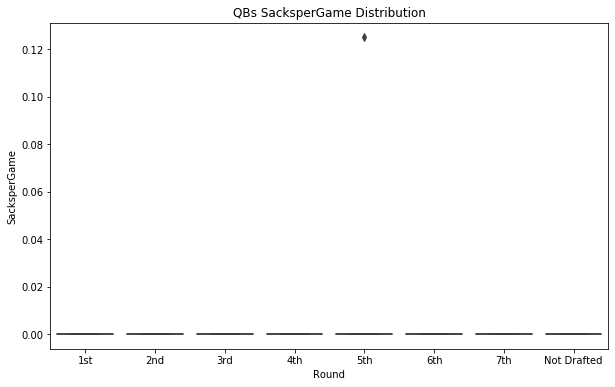

QBs Defensive_InterceptionsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.08
Name: Defensive_InterceptionsperGame, dtype: float64
----------------------------------------
QBs Defensive_InterceptionsperGame by Round
             Defensive_InterceptionsperGame
Round                                      
1st                                    0.00
2nd                                    0.00
3rd                                    0.00
4th                                    0.00
5th                                    0.00
6th                                    0.00
7th                                    0.00
Not Drafted                            0.00


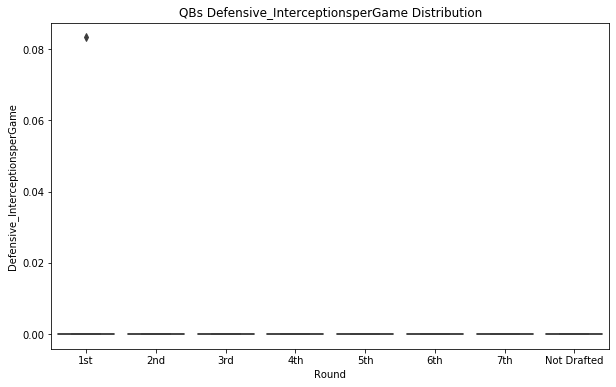

QBs Def_Int_YdsperGame Summary:
count   332.00
mean      0.01
std       0.10
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.75
Name: Def_Int_YdsperGame, dtype: float64
----------------------------------------
QBs Def_Int_YdsperGame by Round
             Def_Int_YdsperGame
Round                          
1st                        0.03
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


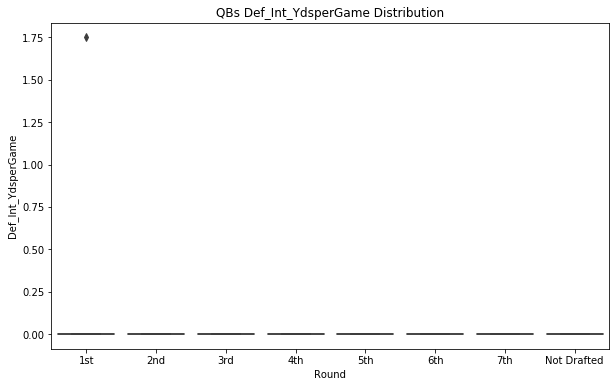

QBs Pick_6perGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pick_6perGame, dtype: float64
----------------------------------------
QBs Pick_6perGame by Round
             Pick_6perGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


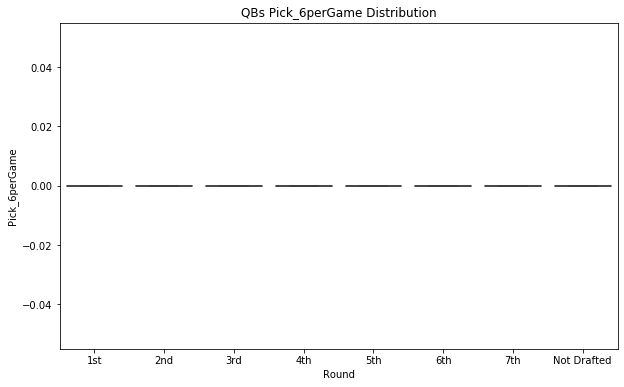

QBs Defended_PassesperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Defended_PassesperGame, dtype: float64
----------------------------------------
QBs Defended_PassesperGame by Round
             Defended_PassesperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


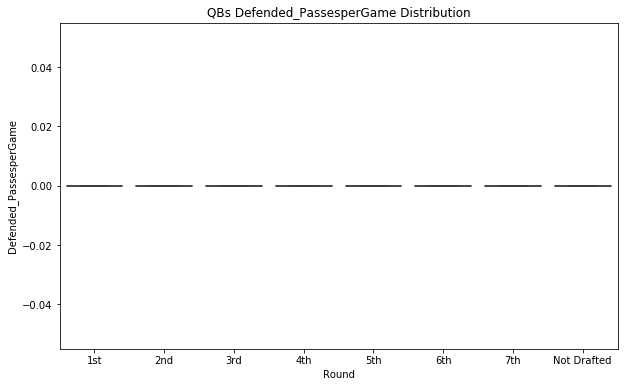

QBs Recovered_FumblesperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Recovered_FumblesperGame, dtype: float64
----------------------------------------
QBs Recovered_FumblesperGame by Round
             Recovered_FumblesperGame
Round                                
1st                              0.00
2nd                              0.00
3rd                              0.00
4th                              0.00
5th                              0.00
6th                              0.00
7th                              0.00
Not Drafted                      0.00


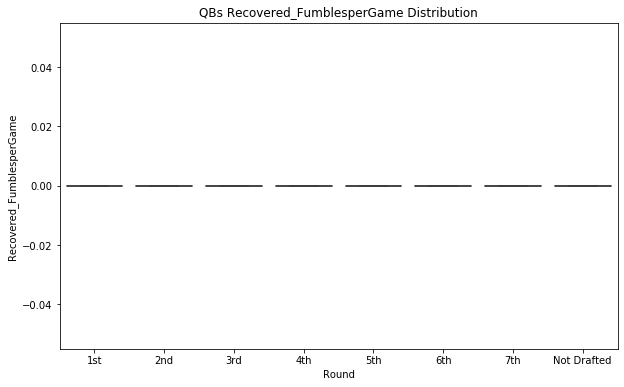

QBs Rec_Fumbles_YdsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Rec_Fumbles_YdsperGame, dtype: float64
----------------------------------------
QBs Rec_Fumbles_YdsperGame by Round
             Rec_Fumbles_YdsperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


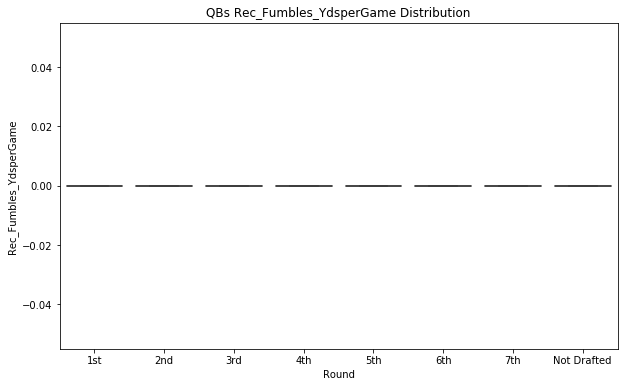

QBs Fumbles_Returned_TDperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Fumbles_Returned_TDperGame, dtype: float64
----------------------------------------
QBs Fumbles_Returned_TDperGame by Round
             Fumbles_Returned_TDperGame
Round                                  
1st                                0.00
2nd                                0.00
3rd                                0.00
4th                                0.00
5th                                0.00
6th                                0.00
7th                                0.00
Not Drafted                        0.00


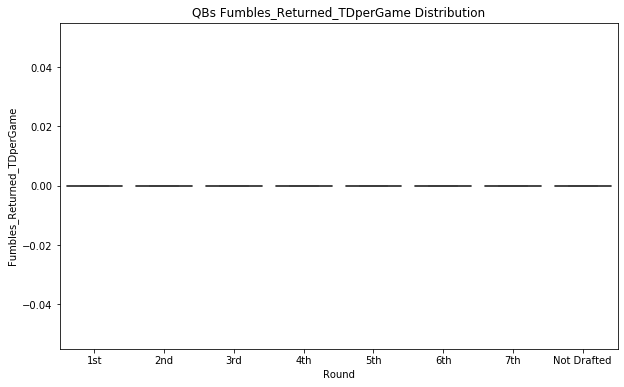

QBs Forced_FumblesperGame Summary:
count   332.00
mean      0.00
std       0.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.15
Name: Forced_FumblesperGame, dtype: float64
----------------------------------------
QBs Forced_FumblesperGame by Round
             Forced_FumblesperGame
Round                             
1st                           0.00
2nd                           0.01
3rd                           0.00
4th                           0.00
5th                           0.00
6th                           0.00
7th                           0.00
Not Drafted                   0.00


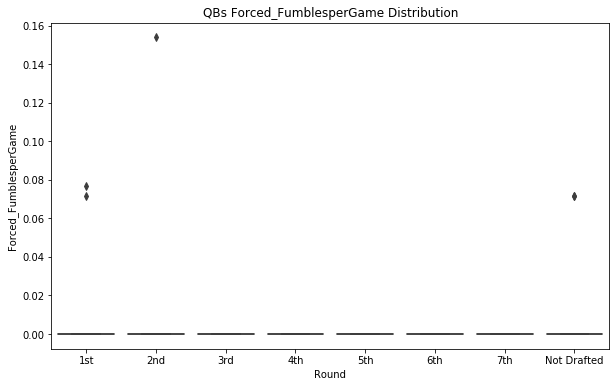

In [528]:
plot_stats('QBs', QB_df, defense_stats)

In [529]:
for i in defense_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', QB_df, i)
    print('')
    print('*' * 40)

Defense_Games ANOVA Test:
----------------------------------------
             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00   619.69    88.53 2.33    0.02
Residual 324.00 12315.18    38.01  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd   0.9911    0.9  -3.7883 5.7705  False
   1st         3rd  -1.7498    0.9  -6.2384 2.7387  False
   1st         4th  -4.1041 0.0761  -8.4205 0.2122  False
   1st         5th  -1.5565    0.9  -6.1103 2.9973  False
   1st         6th  -1.5369    0.9  -5.5867  2.513  False
   1st         7th  -3.8298 0.1586  -8.3184 0.6587  False
   1st Not Drafted  -0.8726    0.9  -3.8802 2.1351  False
   2nd         3rd   -2.741 0.7808  -8.3085 2.8266  False
   2nd         4th  -5.0952 0.0841 -10.5249 0.3344  False
   2nd         5th  -2.5476 0.8514  -8.1679 3.0726  False
   2nd         6th   -2.528 0.7953  -

             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00    0.01     0.00 0.66    0.71
Residual 324.00    0.98     0.00  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0169    0.9 -0.0597 0.0258  False
   1st         3rd  -0.0169    0.9 -0.0571 0.0232  False
   1st         4th  -0.0169 0.8764 -0.0555 0.0216  False
   1st         5th  -0.0169    0.9 -0.0576 0.0237  False
   1st         6th  -0.0169  0.824 -0.0531 0.0192  False
   1st         7th  -0.0169    0.9 -0.0571 0.0232  False
   1st Not Drafted  -0.0169 0.5301 -0.0438 0.0099  False
   2nd         3rd      0.0    0.9 -0.0497 0.0497  False
   2nd         4th      0.0    0.9 -0.0485 0.0485  False
   2nd         5th      0.0    0.9 -0.0502 0.0502  False
   2nd         6th      0.0    0.9 -0.0466 0.0466  False
   2nd         7th      0.0    0.9 -0.0497 0.0497  False
   2nd


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1s


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  Fal

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd     0.01    0.9 -0.2626 0.2826  False
   1st         3rd  -0.0195    0.9 -0.2755 0.2365  False
   1st         4th  -0.0356    0.9 -0.2818 0.2106  False
   1st         5th   0.2404 0.0927 -0.0194 0.5001  False
   1st         6th   0.0059    0.9 -0.2251 0.2369  False
   1st         7th  -0.0096    0.9 -0.2656 0.2464  False
   1st Not Drafted   0.0048    0.9 -0.1668 0.1763  False
   2nd         3rd  -0.0295    0.9 -0.3471  0.288  False
   2nd         4th  -0.0456    0.9 -0.3553 0.2641  False
   2nd         5th   0.2303 0.3602 -0.0902 0.5509  False
   2nd         6th  -0.0041    0.9 -0.3019 0.2936  False
   2nd         7th  -0.0196    0.9 -0.3372 0.2979  False
   2nd Not Drafted  -0.0053    0.9 -0.2597 0.2491  False
   3rd         4th  -0.0161    0.9 -0.3113 0.2791  False
   3rd         5th   0.2599  0.


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1s

### College Stats - Kicking

In [543]:
kicking_stats = ['Kicking_Games', 'XP_Made', 'XP_Attempts', 'XP_Percent', 'FG_Made', 'FG_Attempts', 'FG_Percent', 
                 'TTL_Kicking_Points', 'NumPunts', 'Punt_Yds', 'Yds_per_Punt', 'XP_MadeperGame', 'XP_AttemptsperGame',
                 'FG_MadeperGame', 'FG_AttemptsperGame', 'TTL_Kicking_PointsperGame', 'NumPuntsperGame', 
                 'Punt_YdsperGame']

QBs Kicking_Games Summary:
count   332.00
mean      0.08
std       1.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      13.00
Name: Kicking_Games, dtype: float64
----------------------------------------
QBs Kicking_Games by Round
             Kicking_Games
Round                     
1st                   0.22
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.38
7th                   0.00
Not Drafted           0.00


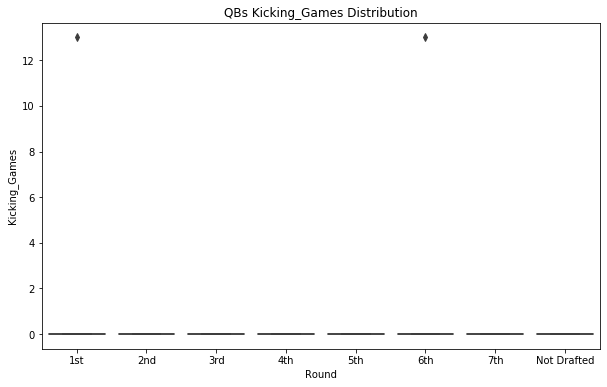

QBs XP_Made Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: XP_Made, dtype: float64
----------------------------------------
QBs XP_Made by Round
             XP_Made
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.00
7th             0.00
Not Drafted     0.00


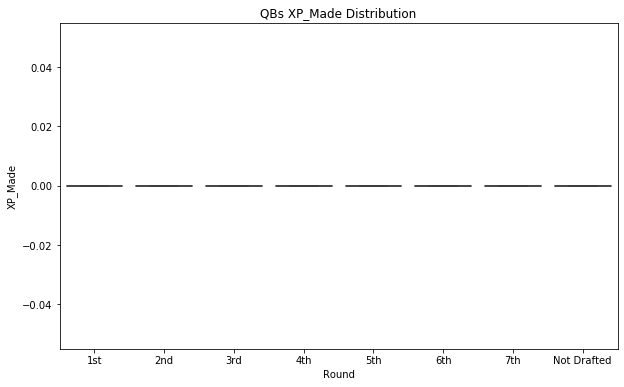

QBs XP_Attempts Summary:
count   332.00
mean      0.00
std       0.05
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: XP_Attempts, dtype: float64
----------------------------------------
QBs XP_Attempts by Round
             XP_Attempts
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.03
7th                 0.00
Not Drafted         0.00


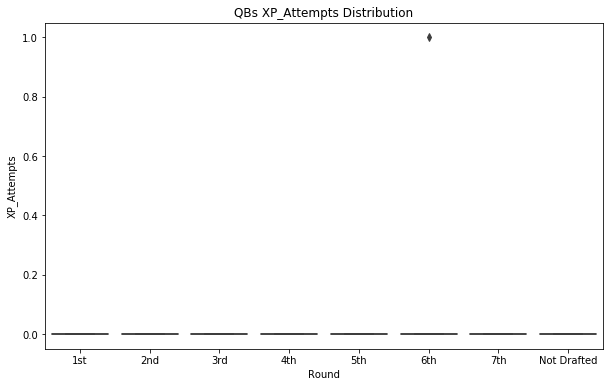

QBs XP_Percent Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: XP_Percent, dtype: float64
----------------------------------------
QBs XP_Percent by Round
             XP_Percent
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                0.00
7th                0.00
Not Drafted        0.00


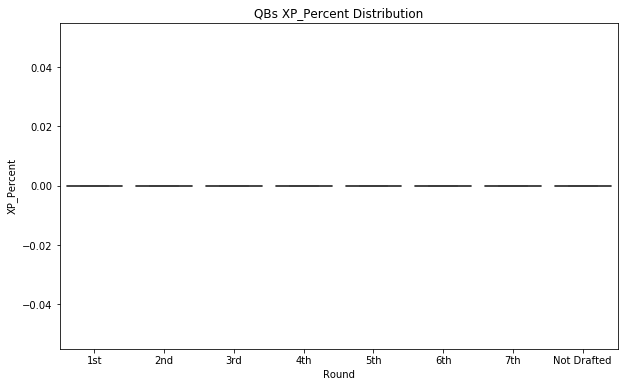

QBs FG_Made Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: FG_Made, dtype: float64
----------------------------------------
QBs FG_Made by Round
             FG_Made
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.00
7th             0.00
Not Drafted     0.00


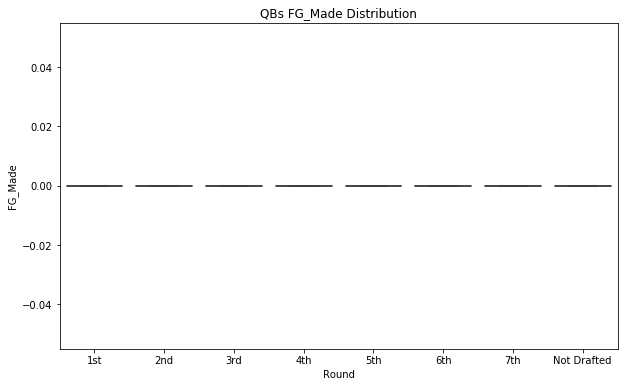

QBs FG_Attempts Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: FG_Attempts, dtype: float64
----------------------------------------
QBs FG_Attempts by Round
             FG_Attempts
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


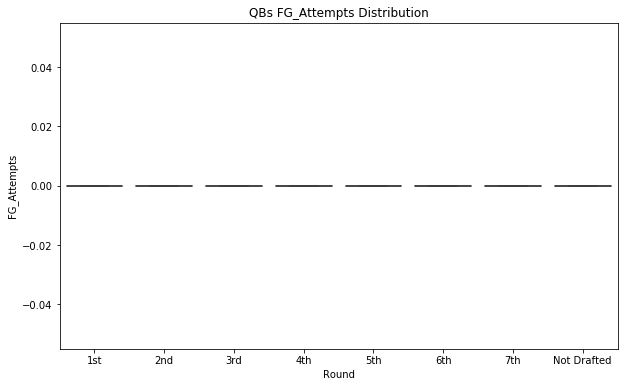

QBs FG_Percent Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: FG_Percent, dtype: float64
----------------------------------------
QBs FG_Percent by Round
             FG_Percent
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                0.00
7th                0.00
Not Drafted        0.00


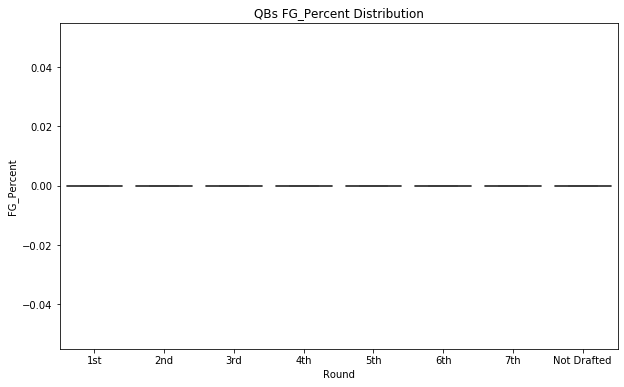

QBs TTL_Kicking_Points Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TTL_Kicking_Points, dtype: float64
----------------------------------------
QBs TTL_Kicking_Points by Round
             TTL_Kicking_Points
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


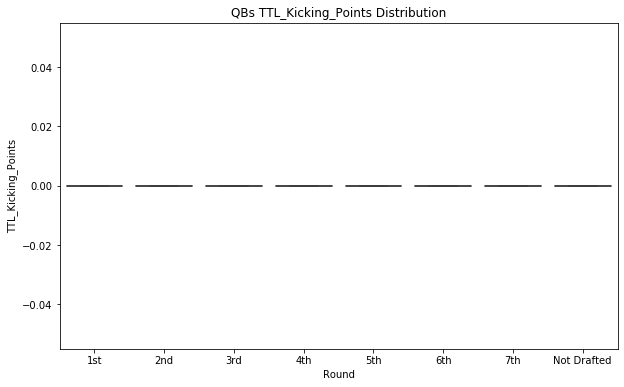

QBs NumPunts Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: NumPunts, dtype: float64
----------------------------------------
QBs NumPunts by Round
             NumPunts
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


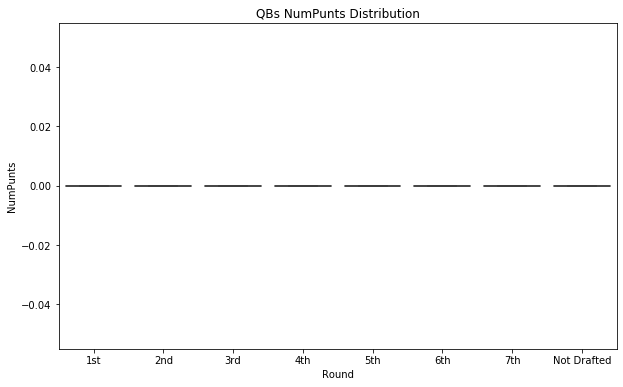

QBs Punt_Yds Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Punt_Yds, dtype: float64
----------------------------------------
QBs Punt_Yds by Round
             Punt_Yds
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


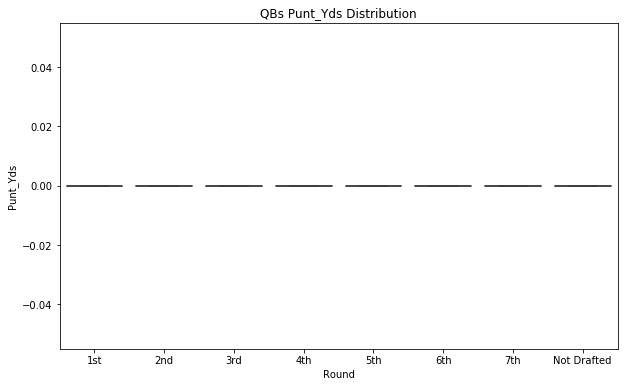

QBs Yds_per_Punt Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Yds_per_Punt, dtype: float64
----------------------------------------
QBs Yds_per_Punt by Round
             Yds_per_Punt
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  0.00
5th                  0.00
6th                  0.00
7th                  0.00
Not Drafted          0.00


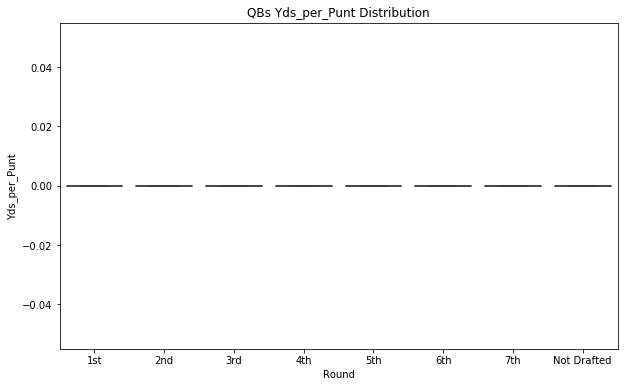

QBs XP_MadeperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: XP_MadeperGame, dtype: float64
----------------------------------------
QBs XP_MadeperGame by Round
             XP_MadeperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.00


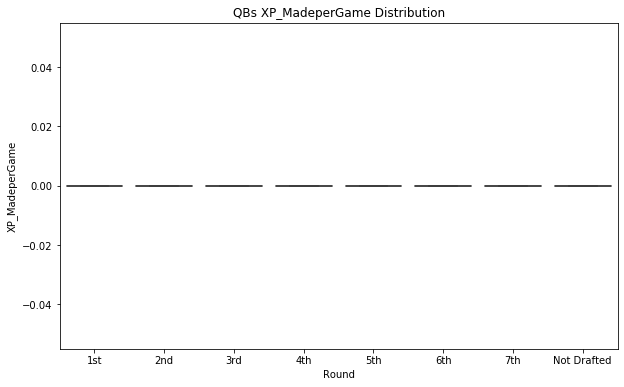

QBs XP_AttemptsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.08
Name: XP_AttemptsperGame, dtype: float64
----------------------------------------
QBs XP_AttemptsperGame by Round
             XP_AttemptsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


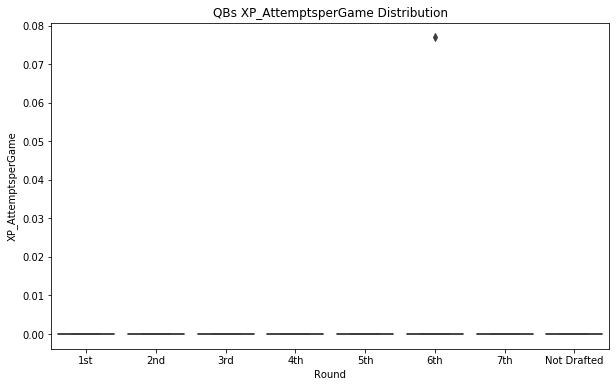

QBs FG_MadeperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: FG_MadeperGame, dtype: float64
----------------------------------------
QBs FG_MadeperGame by Round
             FG_MadeperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.00


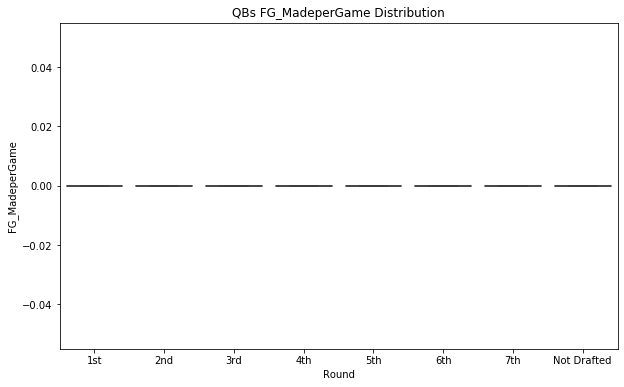

QBs FG_AttemptsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: FG_AttemptsperGame, dtype: float64
----------------------------------------
QBs FG_AttemptsperGame by Round
             FG_AttemptsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


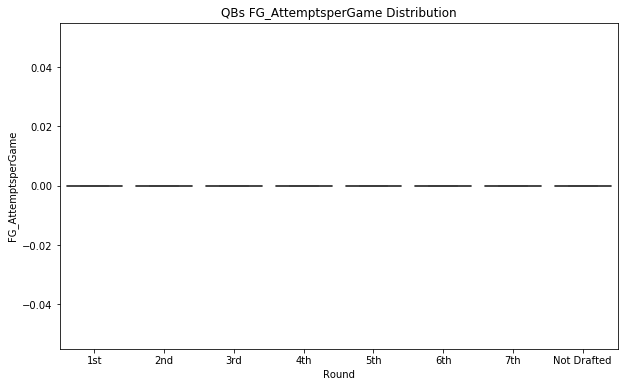

QBs TTL_Kicking_PointsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TTL_Kicking_PointsperGame, dtype: float64
----------------------------------------
QBs TTL_Kicking_PointsperGame by Round
             TTL_Kicking_PointsperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


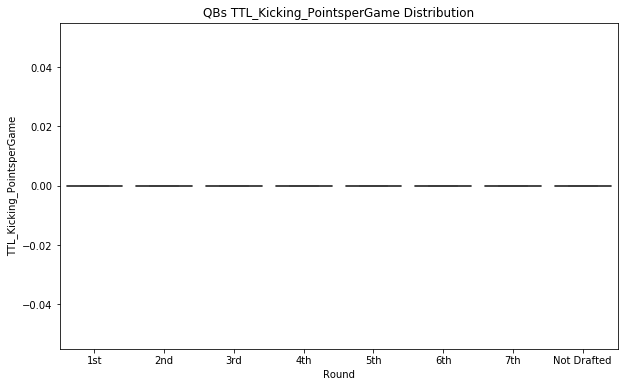

QBs NumPuntsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: NumPuntsperGame, dtype: float64
----------------------------------------
QBs NumPuntsperGame by Round
             NumPuntsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


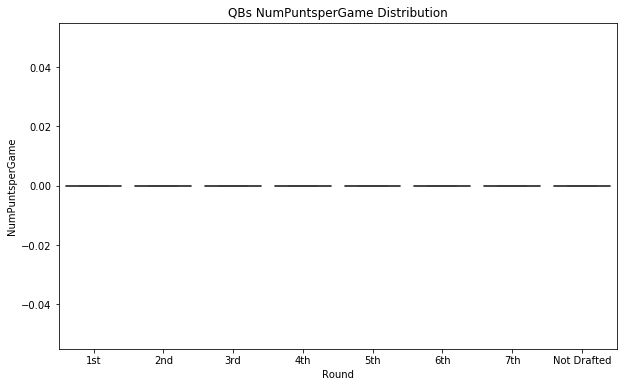

QBs Punt_YdsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Punt_YdsperGame, dtype: float64
----------------------------------------
QBs Punt_YdsperGame by Round
             Punt_YdsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


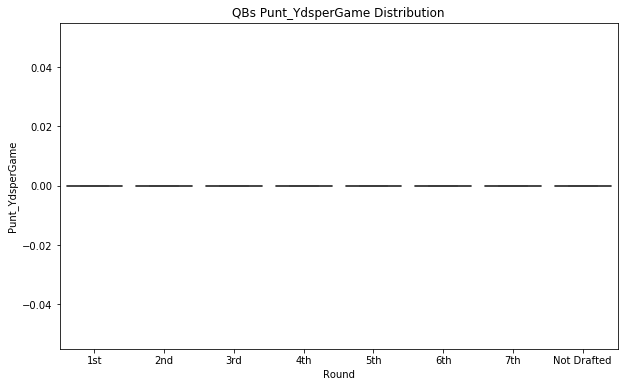

In [544]:
plot_stats('QBs', QB_df, kicking_stats)

In [545]:
for i in kicking_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', QB_df, i)
    print('')
    print('*' * 40)

Kicking_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00    5.80     0.83 0.81    0.58
Residual 324.00  330.17     1.02  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.2203    0.9 -1.0029 0.5622  False
   1st         3rd  -0.2203    0.9 -0.9553 0.5146  False
   1st         4th  -0.2203    0.9 -0.9271 0.4864  False
   1st         5th  -0.2203    0.9  -0.966 0.5253  False
   1st         6th    0.162    0.9 -0.5011 0.8251  False
   1st         7th  -0.2203    0.9 -0.9553 0.5146  False
   1st Not Drafted  -0.2203 0.8621 -0.7128 0.2721  False
   2nd         3rd      0.0    0.9 -0.9116 0.9116  False
   2nd         4th      0.0    0.9  -0.889  0.889  False
   2nd         5th      0.0    0.9 -0.9202 0.9202  False
   2nd         6th   0.3824 0.8622 -0.4724 1.2371  Fa


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  Fal

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  Fals


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.

### College Stats - Punt Returns

In [547]:
puntret_stats = ['PuntRet_Games', 'Kickoff_Returns', 'KO_Return_Yds', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                 'Kickoff_ReturnsperGame', 'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame']

QBs PuntRet_Games Summary:
count   332.00
mean      0.03
std       0.60
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      11.00
Name: PuntRet_Games, dtype: float64
----------------------------------------
QBs PuntRet_Games by Round
             PuntRet_Games
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.09


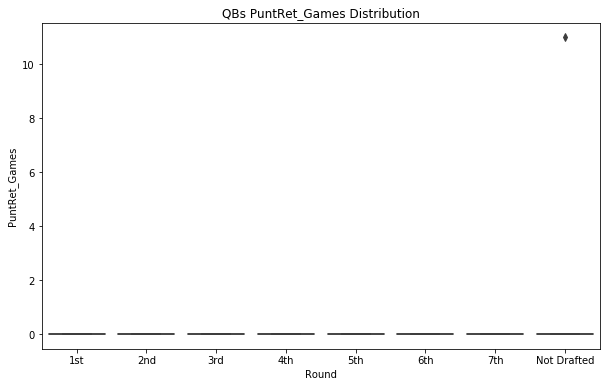

QBs Kickoff_Returns Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Kickoff_Returns, dtype: float64
----------------------------------------
QBs Kickoff_Returns by Round
             Kickoff_Returns
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


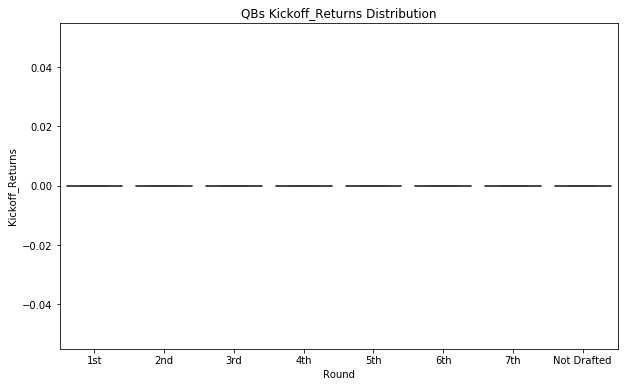

QBs KO_Return_Yds Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Return_Yds, dtype: float64
----------------------------------------
QBs KO_Return_Yds by Round
             KO_Return_Yds
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


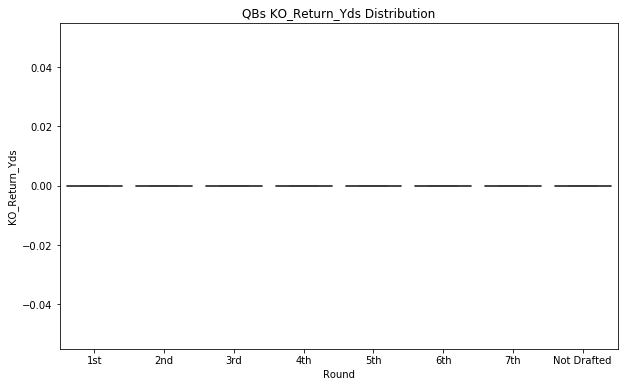

QBs Yds_per_KO_Return Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Yds_per_KO_Return, dtype: float64
----------------------------------------
QBs Yds_per_KO_Return by Round
             Yds_per_KO_Return
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


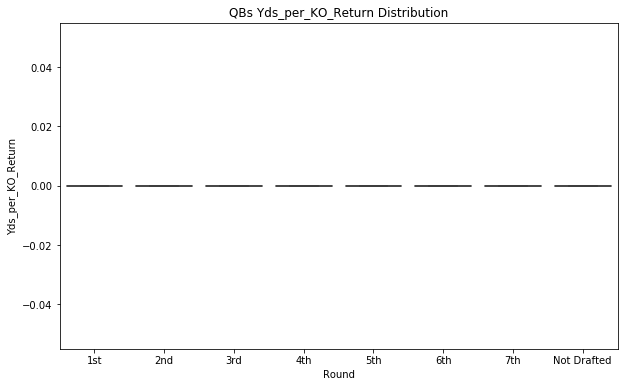

QBs KO_Returned_for_TD Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Returned_for_TD, dtype: float64
----------------------------------------
QBs KO_Returned_for_TD by Round
             KO_Returned_for_TD
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


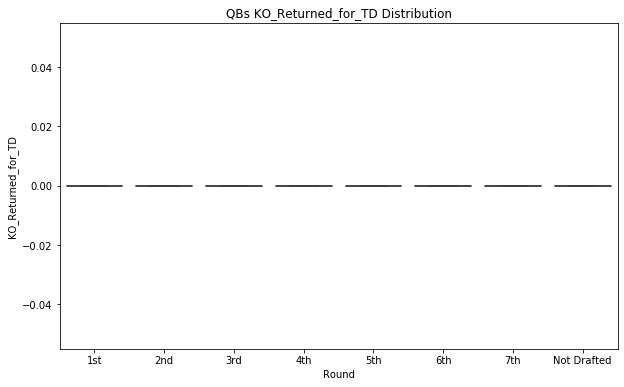

QBs Kickoff_ReturnsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Kickoff_ReturnsperGame, dtype: float64
----------------------------------------
QBs Kickoff_ReturnsperGame by Round
             Kickoff_ReturnsperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


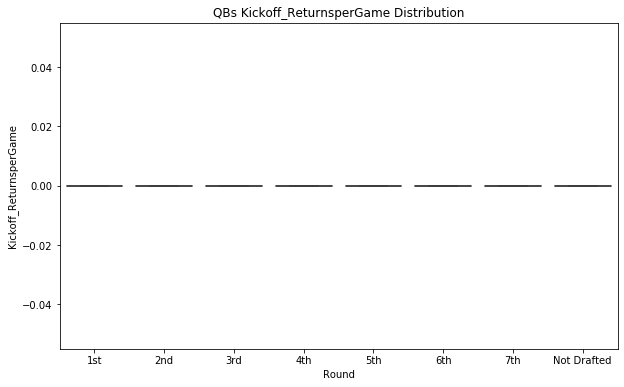

QBs KO_Return_YdsperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Return_YdsperGame, dtype: float64
----------------------------------------
QBs KO_Return_YdsperGame by Round
             KO_Return_YdsperGame
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.00


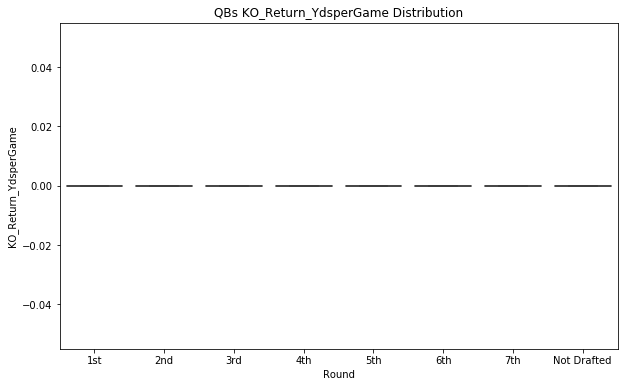

QBs KO_Returned_for_TDperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Returned_for_TDperGame, dtype: float64
----------------------------------------
QBs KO_Returned_for_TDperGame by Round
             KO_Returned_for_TDperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


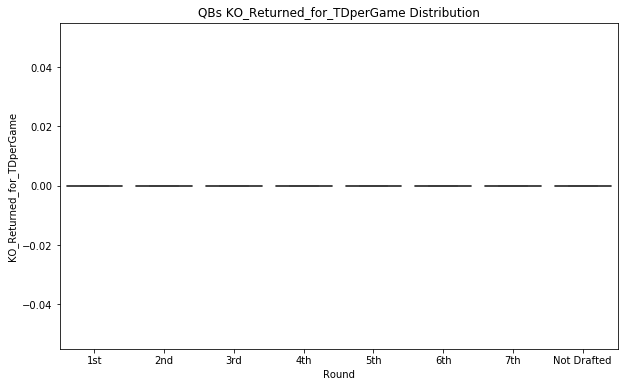

In [548]:
plot_stats('QBs', QB_df, puntret_stats)

In [546]:
for i in puntret_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', QB_df, i)
    print('')
    print('*' * 40)

PuntRet_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00    0.68     0.10 0.26    0.97
Residual 324.00  119.96     0.37  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1    group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------
   1st         2nd      0.0   0.9 -0.4717 0.4717  False
   1st         3rd      0.0   0.9  -0.443  0.443  False
   1st         4th      0.0   0.9  -0.426  0.426  False
   1st         5th      0.0   0.9 -0.4494 0.4494  False
   1st         6th      0.0   0.9 -0.3997 0.3997  False
   1st         7th      0.0   0.9  -0.443  0.443  False
   1st Not Drafted   0.0948   0.9  -0.202 0.3917  False
   2nd         3rd      0.0   0.9 -0.5495 0.5495  False
   2nd         4th      0.0   0.9 -0.5359 0.5359  False
   2nd         5th      0.0   0.9 -0.5547 0.5547  False
   2nd         6th      0.0   0.9 -0.5152 0.5152  False
   2nd    

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  False
   1st         6th      0.0 0.5566   0.0   0.0  False
   1st         7th      0.0 0.5566   0.0   0.0  False
   1st Not Drafted      0.0 0.5566   0.0   0.0  False
   2nd         3rd      0.0 0.5566   0.0   0.0  False
   2nd         4th      0.0 0.5566   0.0   0.0  False
   2nd         5th      0.0 0.5566   0.0   0.0  False


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  False
   1st         6th      0.0 0.5566   0.0   0.0  False
   1st         7th      0.0 0.5566   0.0   0.0  False
   1st Not Drafted      0.0 0.5566   0.0   0.0  False
   2nd         3rd      0.0 0.5566   0.0   0.0  False
   2nd         4th      0.0 0.5566   0.0   0.0  False
   2nd         5th      0.0 0.5566   0.0   0.0  Fals

### College Stats - Scoring

In [549]:
scoring_stats = ['Scoring_Games', 'TD_Other', 'Ttl_TDs', 'TwoPT_Conversion', 'Safety', 'TTL_Points', 'TD_OtherperGame',
                 'Ttl_TDsperGame', 'TwoPT_ConversionperGame', 'SafetyperGame', 'TTL_PointsperGame']

QBs Scoring_Games Summary:
count   332.00
mean     11.75
std       2.78
min       0.00
25%      11.00
50%      13.00
75%      13.00
max      15.00
Name: Scoring_Games, dtype: float64
----------------------------------------
QBs Scoring_Games by Round
             Scoring_Games
Round                     
1st                  12.42
2nd                  11.38
3rd                  11.64
4th                  11.43
5th                  11.62
6th                  11.09
7th                  12.56
Not Drafted          11.62


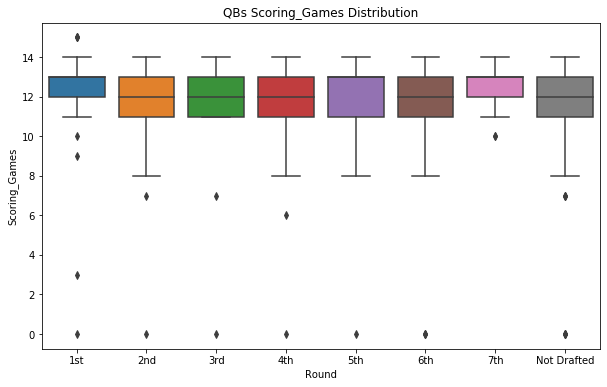

QBs TD_Other Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TD_Other, dtype: float64
----------------------------------------
QBs TD_Other by Round
             TD_Other
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


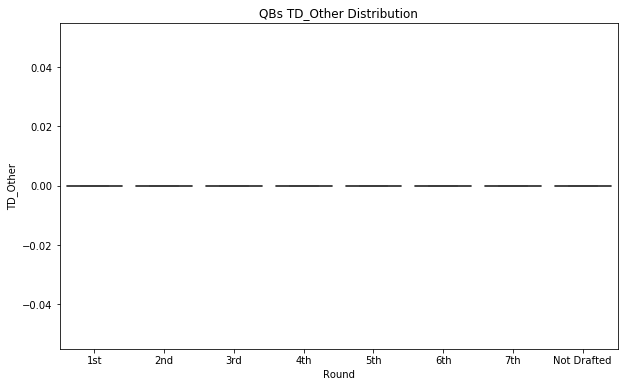

QBs Ttl_TDs Summary:
count   332.00
mean      4.37
std       4.93
min       0.00
25%       1.00
50%       3.00
75%       6.00
max      30.00
Name: Ttl_TDs, dtype: float64
----------------------------------------
QBs Ttl_TDs by Round
             Ttl_TDs
Round               
1st             5.15
2nd             5.43
3rd             3.04
4th             3.50
5th             3.71
6th             4.56
7th             3.16
Not Drafted     4.61


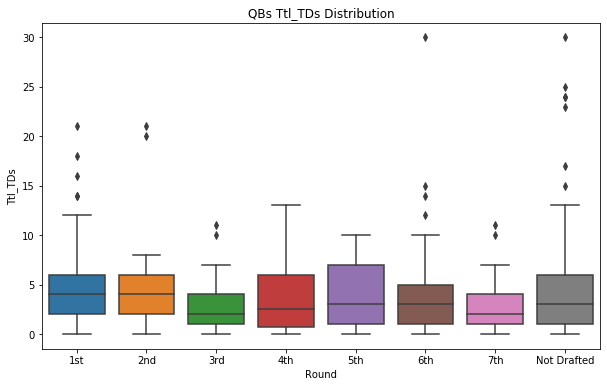

QBs TwoPT_Conversion Summary:
count   332.00
mean      0.01
std       0.12
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.00
Name: TwoPT_Conversion, dtype: float64
----------------------------------------
QBs TwoPT_Conversion by Round
             TwoPT_Conversion
Round                        
1st                      0.00
2nd                      0.00
3rd                      0.00
4th                      0.00
5th                      0.00
6th                      0.00
7th                      0.00
Not Drafted              0.03


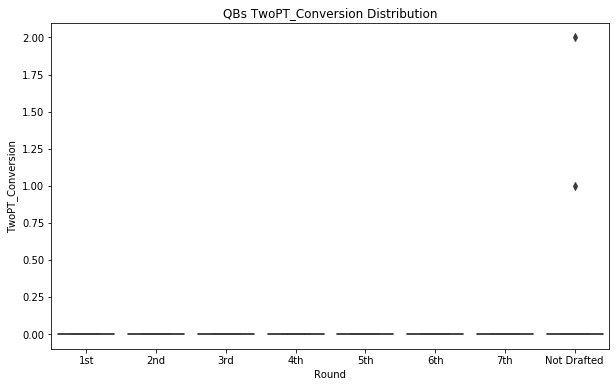

QBs Safety Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Safety, dtype: float64
----------------------------------------
QBs Safety by Round
             Safety
Round              
1st            0.00
2nd            0.00
3rd            0.00
4th            0.00
5th            0.00
6th            0.00
7th            0.00
Not Drafted    0.00


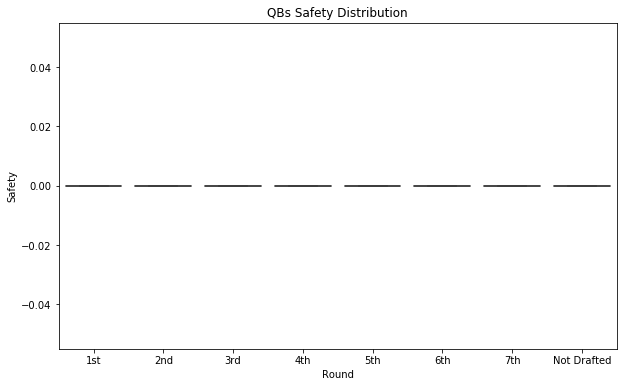

QBs TTL_Points Summary:
count   332.00
mean     24.25
std      25.46
min       0.00
25%       6.00
50%      18.00
75%      36.00
max     144.00
Name: TTL_Points, dtype: float64
----------------------------------------
QBs TTL_Points by Round
             TTL_Points
Round                  
1st               30.92
2nd               32.57
3rd               18.24
4th               21.00
5th               22.25
6th               22.06
7th               18.96
Not Drafted       23.64


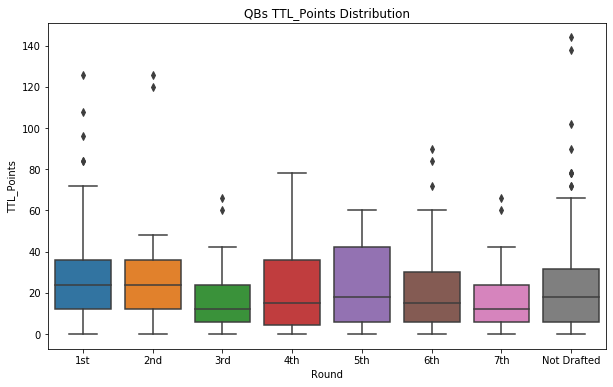

QBs TD_OtherperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TD_OtherperGame, dtype: float64
----------------------------------------
QBs TD_OtherperGame by Round
             TD_OtherperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


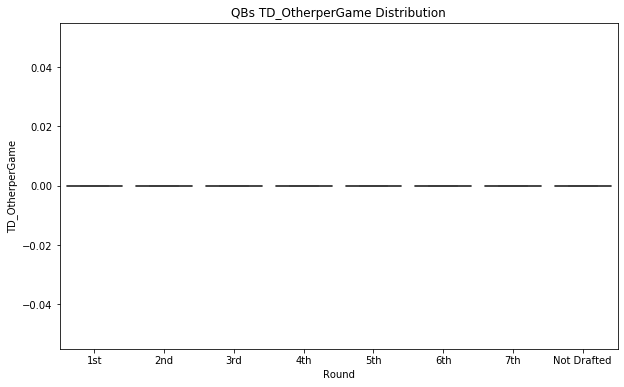

QBs Ttl_TDsperGame Summary:
count   332.00
mean      0.35
std       0.38
min       0.00
25%       0.08
50%       0.24
75%       0.46
max       2.50
Name: Ttl_TDsperGame, dtype: float64
----------------------------------------
QBs Ttl_TDsperGame by Round
             Ttl_TDsperGame
Round                      
1st                    0.40
2nd                    0.43
3rd                    0.24
4th                    0.29
5th                    0.31
6th                    0.36
7th                    0.25
Not Drafted            0.37


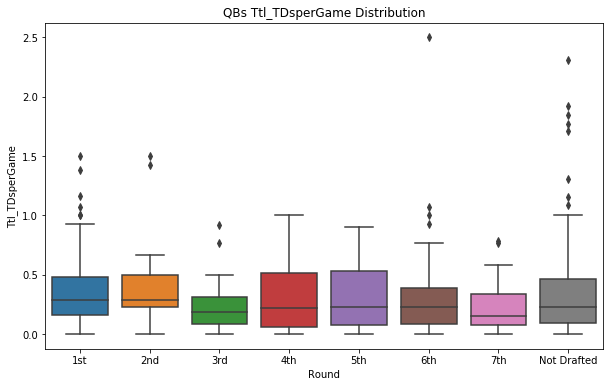

QBs TwoPT_ConversionperGame Summary:
count   332.00
mean      0.00
std       0.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.17
Name: TwoPT_ConversionperGame, dtype: float64
----------------------------------------
QBs TwoPT_ConversionperGame by Round
             TwoPT_ConversionperGame
Round                               
1st                             0.00
2nd                             0.00
3rd                             0.00
4th                             0.00
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.00


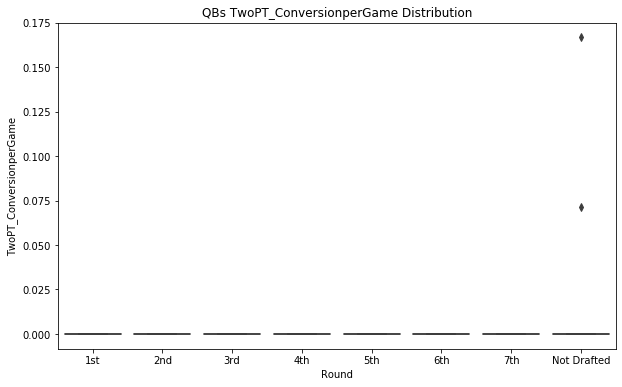

QBs SafetyperGame Summary:
count   332.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: SafetyperGame, dtype: float64
----------------------------------------
QBs SafetyperGame by Round
             SafetyperGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


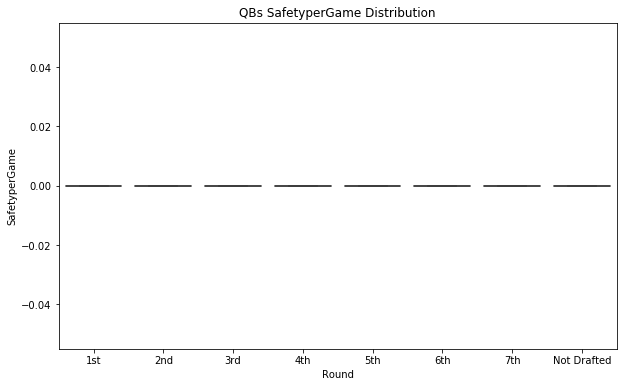

QBs TTL_PointsperGame Summary:
count   332.00
mean      1.94
std       1.94
min       0.00
25%       0.50
50%       1.38
75%       2.77
max      10.62
Name: TTL_PointsperGame, dtype: float64
----------------------------------------
QBs TTL_PointsperGame by Round
             TTL_PointsperGame
Round                         
1st                       2.39
2nd                       2.58
3rd                       1.46
4th                       1.76
5th                       1.85
6th                       1.73
7th                       1.50
Not Drafted               1.92


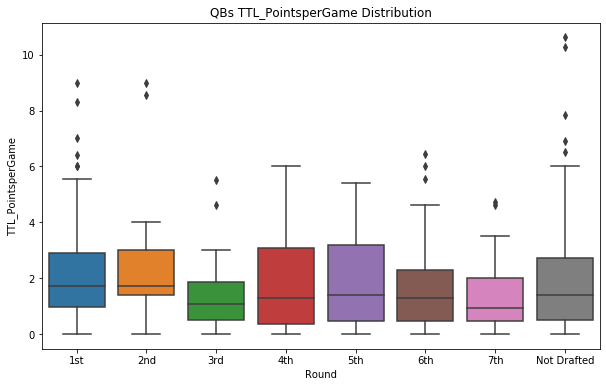

In [550]:
plot_stats('QBs', QB_df, scoring_stats)

In [551]:
for i in scoring_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('QBs', QB_df, i)
    print('')
    print('*' * 40)

Scoring_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   66.44     9.49 1.23    0.28
Residual 324.00 2497.81     7.71  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -1.0428  0.795 -3.1952 1.1097  False
   1st         3rd  -0.7837    0.9 -2.8052 1.2377  False
   1st         4th  -0.9952 0.7452 -2.9391 0.9488  False
   1st         5th  -0.7987    0.9 -2.8496 1.2521  False
   1st         6th  -1.3355 0.3344 -3.1594 0.4884  False
   1st         7th   0.1363    0.9 -1.8852 2.1577  False
   1st Not Drafted   -0.803 0.5987 -2.1576 0.5515  False
   2nd         3rd    0.259    0.9 -2.2483 2.7664  False
   2nd         4th   0.0476    0.9 -2.3977 2.4929  False
   2nd         5th    0.244    0.9 -2.2871 2.7752  False
   2nd         6th  -0.2927    0.9 -2.6437 2.0583  Fa


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.

-------------------------------------------------------

****************************************
SafetyperGame ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq   F  PR(>F)
Round      7.00    0.00     0.00 nan     nan
Residual 324.00    0.00     0.00 nan     nan


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.